In [21]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import pickle as pkl


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [20]:
cd ..

/home/ck/pythonWorkspace


In [22]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [23]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [24]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [25]:
era850 = readERA('v850')
era850 = era850.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [302]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = era850.salem.lookup_transform(topo)

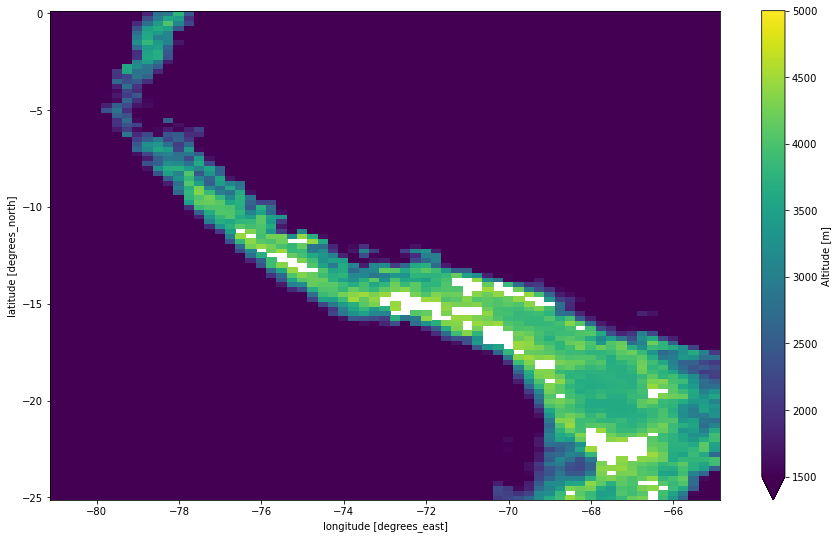

In [324]:
plt.figure(figsize=(15,9))
topo_on_g.where(topo_on_g<4500).plot(vmin=1500, vmax=5000)

In [313]:
topo_on_g

<xarray.DataArray 'h' (latitude: 101, longitude: 65)>
array([[   0.        ,    0.        ,    0.        , ..., 1281.6952381 ,
        1293.76190476,  950.89285714],
       [   0.        ,    0.        ,    0.        , ..., 1564.88888889,
        1208.09777778,  786.79166667],
       [   0.        ,    0.        ,    0.        , ..., 2533.84      ,
        1179.37777778,  746.075     ],
       ...,
       [   0.        ,    0.        ,   27.77333333, ...,   54.16444444,
          53.2       ,   52.18333333],
       [   0.        ,    0.        ,   10.41333333, ...,   58.11555556,
          66.62222222,   72.93333333],
       [   0.        ,    0.        ,    0.        , ...,   66.7       ,
          75.15      ,   86.28125   ]])
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
Attributes:
    long_name:   Altitude
    units:       m
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [256]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
tir_monthly = tir_doypick.resample(time = '1m').mean()

In [53]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))
chirps_monthly = chirps_doypick.resample(time = '1m').mean()

In [450]:
## places

regions = {
    'equatorial' : [(-5,0)],
    'transition' : [(-8,-5)],
    'central' : [(-12,-8)],
    'southern' : [(-20,-12)]}
h = 2000
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)


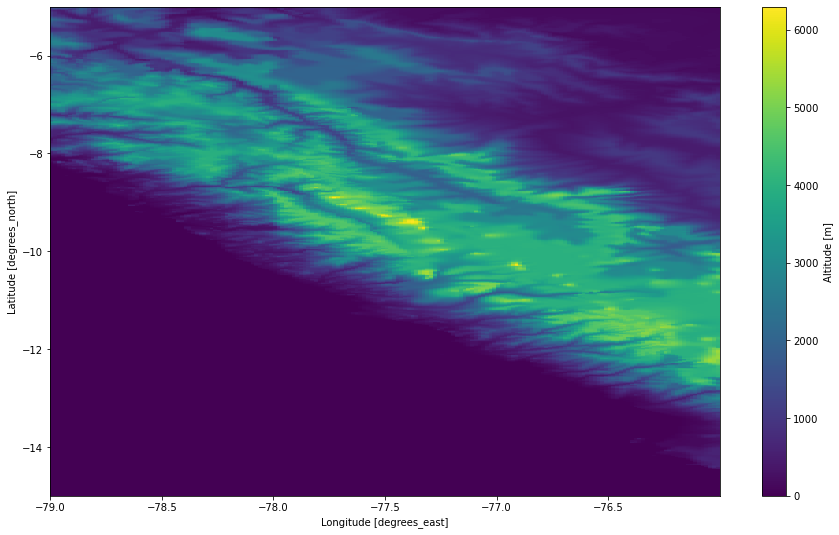

In [451]:
plt.figure(figsize=(15,9))
topo.sel(lat=slice(-15,-5), lon=slice(-79,-76)).plot()#.salem.roi(shape=sdf).plot()

In [35]:
corrdic = pkl.load(open(cnst.network_data + 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [36]:
outarr_3 = corrdic['start_3d']
endarr_5 = corrdic['end_5d']

In [32]:
def dry_wet_chirps(chirps, doy_start, doy_end, dry=False, wet=False):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
        
    ts_rainy = chirps#.where((chirps['time.dayofyear']>=doy_start) | (chirps['time.dayofyear']<=doy_end) &(np.isfinite(tot)))
    
    if wet:
        in_arr = (ts_rainy>=1)
        #in_arr = (ts_rainy<=-4000)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        in_arr = (ts_rainy<1)
        #in_arr = ts_rainy>-4000
        in_arr.values = (in_arr.values.astype(int))
        tag = 'dry'
    
    out_arr = np.zeros((ts_rainy.shape[0],ts_rainy.shape[1], ts_rainy.shape[2]))

    for x in range(ts_rainy.shape[2]):
        for y in range(ts_rainy.shape[1]):
                print('Doing', x, y)
                
                dst = doy_start.isel(latitude=y, longitude=x)
                dse = doy_end.isel(latitude=y, longitude=x)
                if np.isnan(dst) | np.isnan(dse):
                    continue

                ts = in_arr.isel(latitude=y, longitude=x)

                to = tot.isel(latitude=y, longitude=x)
                ts = ts.where((ts['time.dayofyear']>=dst) | (ts['time.dayofyear']<=dse) &(np.isfinite(to)), other=0)
                #ts = ts.where((ts['time.month']>=11) | (ts['time.month']<=4) &(np.isfinite(to)), other=0)
                
                labels, numL = label(ts)

                u, inv = np.unique(labels, return_inverse=True)
                n = np.bincount(inv)

                inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
                inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
                inds_7 = u[(n>=7)&(u!=0)] ## min 5 days breakdown


                if len(inds_3)>0:
                    for i in inds_3:
                        pos = np.where(labels==i)
                        out_arr[pos, y ,x] = 3

                if len(inds_5)>0:
                    for i in inds_5:
                        pos = np.where(labels==i)
                        out_arr[pos, y, x] = 5

                if len(inds_7)>0:
                    for i in inds_7:
                        pos = np.where(labels==i)
                        out_arr[pos, y ,x] = 7

                #ipdb.set_trace()    
    da = xr.DataArray(out_arr, coords=[ts_rainy['time'], ts_rainy['latitude'], ts_rainy['longitude']], dims=['time','latitude','longitude'])                    
        
    da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_spells_1mm_3-7days.nc')
        

In [33]:
def dry_wet_chirps_box(chirps, doy_start, doy_end, dry=False, wet=False, box=None):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
    
    try:
        doys = doy_start.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).median(['latitude','longitude'])
        doye = doy_end.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).median(['latitude','longitude'])
        chirps_box = chirps.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).max(['latitude','longitude'])
    except:
        doys = doy_start.salem.roi(shape=sdf).median(['latitude','longitude'])
        doye = doy_end.salem.roi(shape=sdf).median(['latitude','longitude'])
        chirps_box = chirps.salem.roi(shape=sdf).max(['latitude','longitude'])
    
    #ipdb.set_trace()
    
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box onset', doys.values, 'Date', dstr)
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doye.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box retreat', doye.values, 'Date', dstr)
    #ipdb.set_trace()
    ts_rainy = chirps_box.where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye))
    
    #ch_perc = ts_rainy.groupby('time.year').quantile(0.99)
    
    if wet:
        in_arr = (ts_rainy>=8)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        in_arr = (ts_rainy<=4)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'dry'
    
    out_arr = np.zeros(ts_rainy.shape[0])


    if (np.isnan(doys) | np.isnan(doye)):
        ipdb.set_trace()

    ts = in_arr

    labels, numL = label(ts)

    u, inv = np.unique(labels, return_inverse=True)
    n = np.bincount(inv)

    inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
    inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
    inds_7 = u[(n>=7)&(u!=0)] ## min 5 days breakdown


    if len(inds_3)>0:
        for i in inds_3:
            pos = np.where(labels==i)
            out_arr[pos] = 3

    if len(inds_5)>0:
        for i in inds_5:
            pos = np.where(labels==i)
            out_arr[pos] = 5

    if len(inds_7)>0:
        for i in inds_7:
            pos = np.where(labels==i)
            out_arr[pos] = 7


    da = xr.DataArray(out_arr, coords=[ts_rainy['time']], dims=['time'])                    

#da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_spells_1mm_3-9days.nc')
    return da, ts_rainy, in_arr

In [37]:
dry_wet_chirps(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False)

Doing 0 0
Doing 0 1
Doing 0 2
Doing 0 3
Doing 0 4
Doing 0 5
Doing 0 6
Doing 0 7
Doing 0 8
Doing 0 9
Doing 0 10
Doing 0 11
Doing 0 12
Doing 0 13
Doing 0 14
Doing 0 15
Doing 0 16
Doing 0 17
Doing 0 18
Doing 0 19
Doing 0 20
Doing 0 21
Doing 0 22
Doing 0 23
Doing 0 24
Doing 0 25
Doing 0 26
Doing 0 27
Doing 0 28
Doing 0 29
Doing 0 30
Doing 0 31
Doing 0 32
Doing 0 33
Doing 0 34
Doing 0 35
Doing 0 36
Doing 0 37
Doing 0 38
Doing 0 39
Doing 0 40
Doing 0 41
Doing 0 42
Doing 0 43
Doing 0 44
Doing 0 45
Doing 0 46
Doing 0 47
Doing 0 48
Doing 0 49
Doing 0 50
Doing 0 51
Doing 0 52
Doing 0 53
Doing 0 54
Doing 0 55
Doing 0 56
Doing 0 57
Doing 0 58
Doing 0 59
Doing 0 60
Doing 0 61
Doing 0 62
Doing 0 63
Doing 0 64
Doing 0 65
Doing 0 66
Doing 0 67
Doing 0 68
Doing 0 69
Doing 0 70
Doing 0 71
Doing 0 72
Doing 0 73
Doing 0 74
Doing 0 75
Doing 0 76
Doing 0 77
Doing 0 78
Doing 0 79
Doing 0 80
Doing 0 81
Doing 0 82
Doing 0 83
Doing 0 84
Doing 0 85
Doing 0 86
Doing 0 87
Doing 0 88
Doing 0 89
Doing 0 90
Doing 0 9

Doing 7 67
Doing 7 68
Doing 7 69
Doing 7 70
Doing 7 71
Doing 7 72
Doing 7 73
Doing 7 74
Doing 7 75
Doing 7 76
Doing 7 77
Doing 7 78
Doing 7 79
Doing 7 80
Doing 7 81
Doing 7 82
Doing 7 83
Doing 7 84
Doing 7 85
Doing 7 86
Doing 7 87
Doing 7 88
Doing 7 89
Doing 7 90
Doing 7 91
Doing 7 92
Doing 7 93
Doing 7 94
Doing 7 95
Doing 7 96
Doing 7 97
Doing 7 98
Doing 7 99
Doing 7 100
Doing 8 0
Doing 8 1
Doing 8 2
Doing 8 3
Doing 8 4
Doing 8 5
Doing 8 6
Doing 8 7
Doing 8 8
Doing 8 9
Doing 8 10
Doing 8 11
Doing 8 12
Doing 8 13
Doing 8 14
Doing 8 15
Doing 8 16
Doing 8 17
Doing 8 18
Doing 8 19
Doing 8 20
Doing 8 21
Doing 8 22
Doing 8 23
Doing 8 24
Doing 8 25
Doing 8 26
Doing 8 27
Doing 8 28
Doing 8 29
Doing 8 30
Doing 8 31
Doing 8 32
Doing 8 33
Doing 8 34
Doing 8 35
Doing 8 36
Doing 8 37
Doing 8 38
Doing 8 39
Doing 8 40
Doing 8 41
Doing 8 42
Doing 8 43
Doing 8 44
Doing 8 45
Doing 8 46
Doing 8 47
Doing 8 48
Doing 8 49
Doing 8 50
Doing 8 51
Doing 8 52
Doing 8 53
Doing 8 54
Doing 8 55
Doing 8 56
Doing 8 

Doing 14 71
Doing 14 72
Doing 14 73
Doing 14 74
Doing 14 75
Doing 14 76
Doing 14 77
Doing 14 78
Doing 14 79
Doing 14 80
Doing 14 81
Doing 14 82
Doing 14 83
Doing 14 84
Doing 14 85
Doing 14 86
Doing 14 87
Doing 14 88
Doing 14 89
Doing 14 90
Doing 14 91
Doing 14 92
Doing 14 93
Doing 14 94
Doing 14 95
Doing 14 96
Doing 14 97
Doing 14 98
Doing 14 99
Doing 14 100
Doing 15 0
Doing 15 1
Doing 15 2
Doing 15 3
Doing 15 4
Doing 15 5
Doing 15 6
Doing 15 7
Doing 15 8
Doing 15 9
Doing 15 10
Doing 15 11
Doing 15 12
Doing 15 13
Doing 15 14
Doing 15 15
Doing 15 16
Doing 15 17
Doing 15 18
Doing 15 19
Doing 15 20
Doing 15 21
Doing 15 22
Doing 15 23
Doing 15 24
Doing 15 25
Doing 15 26
Doing 15 27
Doing 15 28
Doing 15 29
Doing 15 30
Doing 15 31
Doing 15 32
Doing 15 33
Doing 15 34
Doing 15 35
Doing 15 36
Doing 15 37
Doing 15 38
Doing 15 39
Doing 15 40
Doing 15 41
Doing 15 42
Doing 15 43
Doing 15 44
Doing 15 45
Doing 15 46
Doing 15 47
Doing 15 48
Doing 15 49
Doing 15 50
Doing 15 51
Doing 15 52
Doing 15 53
D

Doing 21 61
Doing 21 62
Doing 21 63
Doing 21 64
Doing 21 65
Doing 21 66
Doing 21 67
Doing 21 68
Doing 21 69
Doing 21 70
Doing 21 71
Doing 21 72
Doing 21 73
Doing 21 74
Doing 21 75
Doing 21 76
Doing 21 77
Doing 21 78
Doing 21 79
Doing 21 80
Doing 21 81
Doing 21 82
Doing 21 83
Doing 21 84
Doing 21 85
Doing 21 86
Doing 21 87
Doing 21 88
Doing 21 89
Doing 21 90
Doing 21 91
Doing 21 92
Doing 21 93
Doing 21 94
Doing 21 95
Doing 21 96
Doing 21 97
Doing 21 98
Doing 21 99
Doing 21 100
Doing 22 0
Doing 22 1
Doing 22 2
Doing 22 3
Doing 22 4
Doing 22 5
Doing 22 6
Doing 22 7
Doing 22 8
Doing 22 9
Doing 22 10
Doing 22 11
Doing 22 12
Doing 22 13
Doing 22 14
Doing 22 15
Doing 22 16
Doing 22 17
Doing 22 18
Doing 22 19
Doing 22 20
Doing 22 21
Doing 22 22
Doing 22 23
Doing 22 24
Doing 22 25
Doing 22 26
Doing 22 27
Doing 22 28
Doing 22 29
Doing 22 30
Doing 22 31
Doing 22 32
Doing 22 33
Doing 22 34
Doing 22 35
Doing 22 36
Doing 22 37
Doing 22 38
Doing 22 39
Doing 22 40
Doing 22 41
Doing 22 42
Doing 22 43
D

Doing 28 43
Doing 28 44
Doing 28 45
Doing 28 46
Doing 28 47
Doing 28 48
Doing 28 49
Doing 28 50
Doing 28 51
Doing 28 52
Doing 28 53
Doing 28 54
Doing 28 55
Doing 28 56
Doing 28 57
Doing 28 58
Doing 28 59
Doing 28 60
Doing 28 61
Doing 28 62
Doing 28 63
Doing 28 64
Doing 28 65
Doing 28 66
Doing 28 67
Doing 28 68
Doing 28 69
Doing 28 70
Doing 28 71
Doing 28 72
Doing 28 73
Doing 28 74
Doing 28 75
Doing 28 76
Doing 28 77
Doing 28 78
Doing 28 79
Doing 28 80
Doing 28 81
Doing 28 82
Doing 28 83
Doing 28 84
Doing 28 85
Doing 28 86
Doing 28 87
Doing 28 88
Doing 28 89
Doing 28 90
Doing 28 91
Doing 28 92
Doing 28 93
Doing 28 94
Doing 28 95
Doing 28 96
Doing 28 97
Doing 28 98
Doing 28 99
Doing 28 100
Doing 29 0
Doing 29 1
Doing 29 2
Doing 29 3
Doing 29 4
Doing 29 5
Doing 29 6
Doing 29 7
Doing 29 8
Doing 29 9
Doing 29 10
Doing 29 11
Doing 29 12
Doing 29 13
Doing 29 14
Doing 29 15
Doing 29 16
Doing 29 17
Doing 29 18
Doing 29 19
Doing 29 20
Doing 29 21
Doing 29 22
Doing 29 23
Doing 29 24
Doing 29 25
D

Doing 35 26
Doing 35 27
Doing 35 28
Doing 35 29
Doing 35 30
Doing 35 31
Doing 35 32
Doing 35 33
Doing 35 34
Doing 35 35
Doing 35 36
Doing 35 37
Doing 35 38
Doing 35 39
Doing 35 40
Doing 35 41
Doing 35 42
Doing 35 43
Doing 35 44
Doing 35 45
Doing 35 46
Doing 35 47
Doing 35 48
Doing 35 49
Doing 35 50
Doing 35 51
Doing 35 52
Doing 35 53
Doing 35 54
Doing 35 55
Doing 35 56
Doing 35 57
Doing 35 58
Doing 35 59
Doing 35 60
Doing 35 61
Doing 35 62
Doing 35 63
Doing 35 64
Doing 35 65
Doing 35 66
Doing 35 67
Doing 35 68
Doing 35 69
Doing 35 70
Doing 35 71
Doing 35 72
Doing 35 73
Doing 35 74
Doing 35 75
Doing 35 76
Doing 35 77
Doing 35 78
Doing 35 79
Doing 35 80
Doing 35 81
Doing 35 82
Doing 35 83
Doing 35 84
Doing 35 85
Doing 35 86
Doing 35 87
Doing 35 88
Doing 35 89
Doing 35 90
Doing 35 91
Doing 35 92
Doing 35 93
Doing 35 94
Doing 35 95
Doing 35 96
Doing 35 97
Doing 35 98
Doing 35 99
Doing 35 100
Doing 36 0
Doing 36 1
Doing 36 2
Doing 36 3
Doing 36 4
Doing 36 5
Doing 36 6
Doing 36 7
Doing 36 8


Doing 42 31
Doing 42 32
Doing 42 33
Doing 42 34
Doing 42 35
Doing 42 36
Doing 42 37
Doing 42 38
Doing 42 39
Doing 42 40
Doing 42 41
Doing 42 42
Doing 42 43
Doing 42 44
Doing 42 45
Doing 42 46
Doing 42 47
Doing 42 48
Doing 42 49
Doing 42 50
Doing 42 51
Doing 42 52
Doing 42 53
Doing 42 54
Doing 42 55
Doing 42 56
Doing 42 57
Doing 42 58
Doing 42 59
Doing 42 60
Doing 42 61
Doing 42 62
Doing 42 63
Doing 42 64
Doing 42 65
Doing 42 66
Doing 42 67
Doing 42 68
Doing 42 69
Doing 42 70
Doing 42 71
Doing 42 72
Doing 42 73
Doing 42 74
Doing 42 75
Doing 42 76
Doing 42 77
Doing 42 78
Doing 42 79
Doing 42 80
Doing 42 81
Doing 42 82
Doing 42 83
Doing 42 84
Doing 42 85
Doing 42 86
Doing 42 87
Doing 42 88
Doing 42 89
Doing 42 90
Doing 42 91
Doing 42 92
Doing 42 93
Doing 42 94
Doing 42 95
Doing 42 96
Doing 42 97
Doing 42 98
Doing 42 99
Doing 42 100
Doing 43 0
Doing 43 1
Doing 43 2
Doing 43 3
Doing 43 4
Doing 43 5
Doing 43 6
Doing 43 7
Doing 43 8
Doing 43 9
Doing 43 10
Doing 43 11
Doing 43 12
Doing 43 13
D

Doing 49 15
Doing 49 16
Doing 49 17
Doing 49 18
Doing 49 19
Doing 49 20
Doing 49 21
Doing 49 22
Doing 49 23
Doing 49 24
Doing 49 25
Doing 49 26
Doing 49 27
Doing 49 28
Doing 49 29
Doing 49 30
Doing 49 31
Doing 49 32
Doing 49 33
Doing 49 34
Doing 49 35
Doing 49 36
Doing 49 37
Doing 49 38
Doing 49 39
Doing 49 40
Doing 49 41
Doing 49 42
Doing 49 43
Doing 49 44
Doing 49 45
Doing 49 46
Doing 49 47
Doing 49 48
Doing 49 49
Doing 49 50
Doing 49 51
Doing 49 52
Doing 49 53
Doing 49 54
Doing 49 55
Doing 49 56
Doing 49 57
Doing 49 58
Doing 49 59
Doing 49 60
Doing 49 61
Doing 49 62
Doing 49 63
Doing 49 64
Doing 49 65
Doing 49 66
Doing 49 67
Doing 49 68
Doing 49 69
Doing 49 70
Doing 49 71
Doing 49 72
Doing 49 73
Doing 49 74
Doing 49 75
Doing 49 76
Doing 49 77
Doing 49 78
Doing 49 79
Doing 49 80
Doing 49 81
Doing 49 82
Doing 49 83
Doing 49 84
Doing 49 85
Doing 49 86
Doing 49 87
Doing 49 88
Doing 49 89
Doing 49 90
Doing 49 91
Doing 49 92
Doing 49 93
Doing 49 94
Doing 49 95
Doing 49 96
Doing 49 97
Doin

Doing 56 3
Doing 56 4
Doing 56 5
Doing 56 6
Doing 56 7
Doing 56 8
Doing 56 9
Doing 56 10
Doing 56 11
Doing 56 12
Doing 56 13
Doing 56 14
Doing 56 15
Doing 56 16
Doing 56 17
Doing 56 18
Doing 56 19
Doing 56 20
Doing 56 21
Doing 56 22
Doing 56 23
Doing 56 24
Doing 56 25
Doing 56 26
Doing 56 27
Doing 56 28
Doing 56 29
Doing 56 30
Doing 56 31
Doing 56 32
Doing 56 33
Doing 56 34
Doing 56 35
Doing 56 36
Doing 56 37
Doing 56 38
Doing 56 39
Doing 56 40
Doing 56 41
Doing 56 42
Doing 56 43
Doing 56 44
Doing 56 45
Doing 56 46
Doing 56 47
Doing 56 48
Doing 56 49
Doing 56 50
Doing 56 51
Doing 56 52
Doing 56 53
Doing 56 54
Doing 56 55
Doing 56 56
Doing 56 57
Doing 56 58
Doing 56 59
Doing 56 60
Doing 56 61
Doing 56 62
Doing 56 63
Doing 56 64
Doing 56 65
Doing 56 66
Doing 56 67
Doing 56 68
Doing 56 69
Doing 56 70
Doing 56 71
Doing 56 72
Doing 56 73
Doing 56 74
Doing 56 75
Doing 56 76
Doing 56 77
Doing 56 78
Doing 56 79
Doing 56 80
Doing 56 81
Doing 56 82
Doing 56 83
Doing 56 84
Doing 56 85
Doing 56 86

Doing 63 7
Doing 63 8
Doing 63 9
Doing 63 10
Doing 63 11
Doing 63 12
Doing 63 13
Doing 63 14
Doing 63 15
Doing 63 16
Doing 63 17
Doing 63 18
Doing 63 19
Doing 63 20
Doing 63 21
Doing 63 22
Doing 63 23
Doing 63 24
Doing 63 25
Doing 63 26
Doing 63 27
Doing 63 28
Doing 63 29
Doing 63 30
Doing 63 31
Doing 63 32
Doing 63 33
Doing 63 34
Doing 63 35
Doing 63 36
Doing 63 37
Doing 63 38
Doing 63 39
Doing 63 40
Doing 63 41
Doing 63 42
Doing 63 43
Doing 63 44
Doing 63 45
Doing 63 46
Doing 63 47
Doing 63 48
Doing 63 49
Doing 63 50
Doing 63 51
Doing 63 52
Doing 63 53
Doing 63 54
Doing 63 55
Doing 63 56
Doing 63 57
Doing 63 58
Doing 63 59
Doing 63 60
Doing 63 61
Doing 63 62
Doing 63 63
Doing 63 64
Doing 63 65
Doing 63 66
Doing 63 67
Doing 63 68
Doing 63 69
Doing 63 70
Doing 63 71
Doing 63 72
Doing 63 73
Doing 63 74
Doing 63 75
Doing 63 76
Doing 63 77
Doing 63 78
Doing 63 79
Doing 63 80
Doing 63 81
Doing 63 82
Doing 63 83
Doing 63 84
Doing 63 85
Doing 63 86
Doing 63 87
Doing 63 88
Doing 63 89
Doing 6

In [38]:
dry_wet_chirps(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True)

Doing 0 0
Doing 0 1
Doing 0 2
Doing 0 3
Doing 0 4
Doing 0 5
Doing 0 6
Doing 0 7
Doing 0 8
Doing 0 9
Doing 0 10
Doing 0 11
Doing 0 12
Doing 0 13
Doing 0 14
Doing 0 15
Doing 0 16
Doing 0 17
Doing 0 18
Doing 0 19
Doing 0 20
Doing 0 21
Doing 0 22
Doing 0 23
Doing 0 24
Doing 0 25
Doing 0 26
Doing 0 27
Doing 0 28
Doing 0 29
Doing 0 30
Doing 0 31
Doing 0 32
Doing 0 33
Doing 0 34
Doing 0 35
Doing 0 36
Doing 0 37
Doing 0 38
Doing 0 39
Doing 0 40
Doing 0 41
Doing 0 42
Doing 0 43
Doing 0 44
Doing 0 45
Doing 0 46
Doing 0 47
Doing 0 48
Doing 0 49
Doing 0 50
Doing 0 51
Doing 0 52
Doing 0 53
Doing 0 54
Doing 0 55
Doing 0 56
Doing 0 57
Doing 0 58
Doing 0 59
Doing 0 60
Doing 0 61
Doing 0 62
Doing 0 63
Doing 0 64
Doing 0 65
Doing 0 66
Doing 0 67
Doing 0 68
Doing 0 69
Doing 0 70
Doing 0 71
Doing 0 72
Doing 0 73
Doing 0 74
Doing 0 75
Doing 0 76
Doing 0 77
Doing 0 78
Doing 0 79
Doing 0 80
Doing 0 81
Doing 0 82
Doing 0 83
Doing 0 84
Doing 0 85
Doing 0 86
Doing 0 87
Doing 0 88
Doing 0 89
Doing 0 90
Doing 0 9

Doing 7 61
Doing 7 62
Doing 7 63
Doing 7 64
Doing 7 65
Doing 7 66
Doing 7 67
Doing 7 68
Doing 7 69
Doing 7 70
Doing 7 71
Doing 7 72
Doing 7 73
Doing 7 74
Doing 7 75
Doing 7 76
Doing 7 77
Doing 7 78
Doing 7 79
Doing 7 80
Doing 7 81
Doing 7 82
Doing 7 83
Doing 7 84
Doing 7 85
Doing 7 86
Doing 7 87
Doing 7 88
Doing 7 89
Doing 7 90
Doing 7 91
Doing 7 92
Doing 7 93
Doing 7 94
Doing 7 95
Doing 7 96
Doing 7 97
Doing 7 98
Doing 7 99
Doing 7 100
Doing 8 0
Doing 8 1
Doing 8 2
Doing 8 3
Doing 8 4
Doing 8 5
Doing 8 6
Doing 8 7
Doing 8 8
Doing 8 9
Doing 8 10
Doing 8 11
Doing 8 12
Doing 8 13
Doing 8 14
Doing 8 15
Doing 8 16
Doing 8 17
Doing 8 18
Doing 8 19
Doing 8 20
Doing 8 21
Doing 8 22
Doing 8 23
Doing 8 24
Doing 8 25
Doing 8 26
Doing 8 27
Doing 8 28
Doing 8 29
Doing 8 30
Doing 8 31
Doing 8 32
Doing 8 33
Doing 8 34
Doing 8 35
Doing 8 36
Doing 8 37
Doing 8 38
Doing 8 39
Doing 8 40
Doing 8 41
Doing 8 42
Doing 8 43
Doing 8 44
Doing 8 45
Doing 8 46
Doing 8 47
Doing 8 48
Doing 8 49
Doing 8 50
Doing 8 

Doing 14 72
Doing 14 73
Doing 14 74
Doing 14 75
Doing 14 76
Doing 14 77
Doing 14 78
Doing 14 79
Doing 14 80
Doing 14 81
Doing 14 82
Doing 14 83
Doing 14 84
Doing 14 85
Doing 14 86
Doing 14 87
Doing 14 88
Doing 14 89
Doing 14 90
Doing 14 91
Doing 14 92
Doing 14 93
Doing 14 94
Doing 14 95
Doing 14 96
Doing 14 97
Doing 14 98
Doing 14 99
Doing 14 100
Doing 15 0
Doing 15 1
Doing 15 2
Doing 15 3
Doing 15 4
Doing 15 5
Doing 15 6
Doing 15 7
Doing 15 8
Doing 15 9
Doing 15 10
Doing 15 11
Doing 15 12
Doing 15 13
Doing 15 14
Doing 15 15
Doing 15 16
Doing 15 17
Doing 15 18
Doing 15 19
Doing 15 20
Doing 15 21
Doing 15 22
Doing 15 23
Doing 15 24
Doing 15 25
Doing 15 26
Doing 15 27
Doing 15 28
Doing 15 29
Doing 15 30
Doing 15 31
Doing 15 32
Doing 15 33
Doing 15 34
Doing 15 35
Doing 15 36
Doing 15 37
Doing 15 38
Doing 15 39
Doing 15 40
Doing 15 41
Doing 15 42
Doing 15 43
Doing 15 44
Doing 15 45
Doing 15 46
Doing 15 47
Doing 15 48
Doing 15 49
Doing 15 50
Doing 15 51
Doing 15 52
Doing 15 53
Doing 15 54
D

Doing 21 53
Doing 21 54
Doing 21 55
Doing 21 56
Doing 21 57
Doing 21 58
Doing 21 59
Doing 21 60
Doing 21 61
Doing 21 62
Doing 21 63
Doing 21 64
Doing 21 65
Doing 21 66
Doing 21 67
Doing 21 68
Doing 21 69
Doing 21 70
Doing 21 71
Doing 21 72
Doing 21 73
Doing 21 74
Doing 21 75
Doing 21 76
Doing 21 77
Doing 21 78
Doing 21 79
Doing 21 80
Doing 21 81
Doing 21 82
Doing 21 83
Doing 21 84
Doing 21 85
Doing 21 86
Doing 21 87
Doing 21 88
Doing 21 89
Doing 21 90
Doing 21 91
Doing 21 92
Doing 21 93
Doing 21 94
Doing 21 95
Doing 21 96
Doing 21 97
Doing 21 98
Doing 21 99
Doing 21 100
Doing 22 0
Doing 22 1
Doing 22 2
Doing 22 3
Doing 22 4
Doing 22 5
Doing 22 6
Doing 22 7
Doing 22 8
Doing 22 9
Doing 22 10
Doing 22 11
Doing 22 12
Doing 22 13
Doing 22 14
Doing 22 15
Doing 22 16
Doing 22 17
Doing 22 18
Doing 22 19
Doing 22 20
Doing 22 21
Doing 22 22
Doing 22 23
Doing 22 24
Doing 22 25
Doing 22 26
Doing 22 27
Doing 22 28
Doing 22 29
Doing 22 30
Doing 22 31
Doing 22 32
Doing 22 33
Doing 22 34
Doing 22 35
D

Doing 28 50
Doing 28 51
Doing 28 52
Doing 28 53
Doing 28 54
Doing 28 55
Doing 28 56
Doing 28 57
Doing 28 58
Doing 28 59
Doing 28 60
Doing 28 61
Doing 28 62
Doing 28 63
Doing 28 64
Doing 28 65
Doing 28 66
Doing 28 67
Doing 28 68
Doing 28 69
Doing 28 70
Doing 28 71
Doing 28 72
Doing 28 73
Doing 28 74
Doing 28 75
Doing 28 76
Doing 28 77
Doing 28 78
Doing 28 79
Doing 28 80
Doing 28 81
Doing 28 82
Doing 28 83
Doing 28 84
Doing 28 85
Doing 28 86
Doing 28 87
Doing 28 88
Doing 28 89
Doing 28 90
Doing 28 91
Doing 28 92
Doing 28 93
Doing 28 94
Doing 28 95
Doing 28 96
Doing 28 97
Doing 28 98
Doing 28 99
Doing 28 100
Doing 29 0
Doing 29 1
Doing 29 2
Doing 29 3
Doing 29 4
Doing 29 5
Doing 29 6
Doing 29 7
Doing 29 8
Doing 29 9
Doing 29 10
Doing 29 11
Doing 29 12
Doing 29 13
Doing 29 14
Doing 29 15
Doing 29 16
Doing 29 17
Doing 29 18
Doing 29 19
Doing 29 20
Doing 29 21
Doing 29 22
Doing 29 23
Doing 29 24
Doing 29 25
Doing 29 26
Doing 29 27
Doing 29 28
Doing 29 29
Doing 29 30
Doing 29 31
Doing 29 32
D

Doing 35 35
Doing 35 36
Doing 35 37
Doing 35 38
Doing 35 39
Doing 35 40
Doing 35 41
Doing 35 42
Doing 35 43
Doing 35 44
Doing 35 45
Doing 35 46
Doing 35 47
Doing 35 48
Doing 35 49
Doing 35 50
Doing 35 51
Doing 35 52
Doing 35 53
Doing 35 54
Doing 35 55
Doing 35 56
Doing 35 57
Doing 35 58
Doing 35 59
Doing 35 60
Doing 35 61
Doing 35 62
Doing 35 63
Doing 35 64
Doing 35 65
Doing 35 66
Doing 35 67
Doing 35 68
Doing 35 69
Doing 35 70
Doing 35 71
Doing 35 72
Doing 35 73
Doing 35 74
Doing 35 75
Doing 35 76
Doing 35 77
Doing 35 78
Doing 35 79
Doing 35 80
Doing 35 81
Doing 35 82
Doing 35 83
Doing 35 84
Doing 35 85
Doing 35 86
Doing 35 87
Doing 35 88
Doing 35 89
Doing 35 90
Doing 35 91
Doing 35 92
Doing 35 93
Doing 35 94
Doing 35 95
Doing 35 96
Doing 35 97
Doing 35 98
Doing 35 99
Doing 35 100
Doing 36 0
Doing 36 1
Doing 36 2
Doing 36 3
Doing 36 4
Doing 36 5
Doing 36 6
Doing 36 7
Doing 36 8
Doing 36 9
Doing 36 10
Doing 36 11
Doing 36 12
Doing 36 13
Doing 36 14
Doing 36 15
Doing 36 16
Doing 36 17
D

Doing 42 35
Doing 42 36
Doing 42 37
Doing 42 38
Doing 42 39
Doing 42 40
Doing 42 41
Doing 42 42
Doing 42 43
Doing 42 44
Doing 42 45
Doing 42 46
Doing 42 47
Doing 42 48
Doing 42 49
Doing 42 50
Doing 42 51
Doing 42 52
Doing 42 53
Doing 42 54
Doing 42 55
Doing 42 56
Doing 42 57
Doing 42 58
Doing 42 59
Doing 42 60
Doing 42 61
Doing 42 62
Doing 42 63
Doing 42 64
Doing 42 65
Doing 42 66
Doing 42 67
Doing 42 68
Doing 42 69
Doing 42 70
Doing 42 71
Doing 42 72
Doing 42 73
Doing 42 74
Doing 42 75
Doing 42 76
Doing 42 77
Doing 42 78
Doing 42 79
Doing 42 80
Doing 42 81
Doing 42 82
Doing 42 83
Doing 42 84
Doing 42 85
Doing 42 86
Doing 42 87
Doing 42 88
Doing 42 89
Doing 42 90
Doing 42 91
Doing 42 92
Doing 42 93
Doing 42 94
Doing 42 95
Doing 42 96
Doing 42 97
Doing 42 98
Doing 42 99
Doing 42 100
Doing 43 0
Doing 43 1
Doing 43 2
Doing 43 3
Doing 43 4
Doing 43 5
Doing 43 6
Doing 43 7
Doing 43 8
Doing 43 9
Doing 43 10
Doing 43 11
Doing 43 12
Doing 43 13
Doing 43 14
Doing 43 15
Doing 43 16
Doing 43 17
D

Doing 49 32
Doing 49 33
Doing 49 34
Doing 49 35
Doing 49 36
Doing 49 37
Doing 49 38
Doing 49 39
Doing 49 40
Doing 49 41
Doing 49 42
Doing 49 43
Doing 49 44
Doing 49 45
Doing 49 46
Doing 49 47
Doing 49 48
Doing 49 49
Doing 49 50
Doing 49 51
Doing 49 52
Doing 49 53
Doing 49 54
Doing 49 55
Doing 49 56
Doing 49 57
Doing 49 58
Doing 49 59
Doing 49 60
Doing 49 61
Doing 49 62
Doing 49 63
Doing 49 64
Doing 49 65
Doing 49 66
Doing 49 67
Doing 49 68
Doing 49 69
Doing 49 70
Doing 49 71
Doing 49 72
Doing 49 73
Doing 49 74
Doing 49 75
Doing 49 76
Doing 49 77
Doing 49 78
Doing 49 79
Doing 49 80
Doing 49 81
Doing 49 82
Doing 49 83
Doing 49 84
Doing 49 85
Doing 49 86
Doing 49 87
Doing 49 88
Doing 49 89
Doing 49 90
Doing 49 91
Doing 49 92
Doing 49 93
Doing 49 94
Doing 49 95
Doing 49 96
Doing 49 97
Doing 49 98
Doing 49 99
Doing 49 100
Doing 50 0
Doing 50 1
Doing 50 2
Doing 50 3
Doing 50 4
Doing 50 5
Doing 50 6
Doing 50 7
Doing 50 8
Doing 50 9
Doing 50 10
Doing 50 11
Doing 50 12
Doing 50 13
Doing 50 14
D

Doing 56 20
Doing 56 21
Doing 56 22
Doing 56 23
Doing 56 24
Doing 56 25
Doing 56 26
Doing 56 27
Doing 56 28
Doing 56 29
Doing 56 30
Doing 56 31
Doing 56 32
Doing 56 33
Doing 56 34
Doing 56 35
Doing 56 36
Doing 56 37
Doing 56 38
Doing 56 39
Doing 56 40
Doing 56 41
Doing 56 42
Doing 56 43
Doing 56 44
Doing 56 45
Doing 56 46
Doing 56 47
Doing 56 48
Doing 56 49
Doing 56 50
Doing 56 51
Doing 56 52
Doing 56 53
Doing 56 54
Doing 56 55
Doing 56 56
Doing 56 57
Doing 56 58
Doing 56 59
Doing 56 60
Doing 56 61
Doing 56 62
Doing 56 63
Doing 56 64
Doing 56 65
Doing 56 66
Doing 56 67
Doing 56 68
Doing 56 69
Doing 56 70
Doing 56 71
Doing 56 72
Doing 56 73
Doing 56 74
Doing 56 75
Doing 56 76
Doing 56 77
Doing 56 78
Doing 56 79
Doing 56 80
Doing 56 81
Doing 56 82
Doing 56 83
Doing 56 84
Doing 56 85
Doing 56 86
Doing 56 87
Doing 56 88
Doing 56 89
Doing 56 90
Doing 56 91
Doing 56 92
Doing 56 93
Doing 56 94
Doing 56 95
Doing 56 96
Doing 56 97
Doing 56 98
Doing 56 99
Doing 56 100
Doing 57 0
Doing 57 1
Doing

Doing 63 3
Doing 63 4
Doing 63 5
Doing 63 6
Doing 63 7
Doing 63 8
Doing 63 9
Doing 63 10
Doing 63 11
Doing 63 12
Doing 63 13
Doing 63 14
Doing 63 15
Doing 63 16
Doing 63 17
Doing 63 18
Doing 63 19
Doing 63 20
Doing 63 21
Doing 63 22
Doing 63 23
Doing 63 24
Doing 63 25
Doing 63 26
Doing 63 27
Doing 63 28
Doing 63 29
Doing 63 30
Doing 63 31
Doing 63 32
Doing 63 33
Doing 63 34
Doing 63 35
Doing 63 36
Doing 63 37
Doing 63 38
Doing 63 39
Doing 63 40
Doing 63 41
Doing 63 42
Doing 63 43
Doing 63 44
Doing 63 45
Doing 63 46
Doing 63 47
Doing 63 48
Doing 63 49
Doing 63 50
Doing 63 51
Doing 63 52
Doing 63 53
Doing 63 54
Doing 63 55
Doing 63 56
Doing 63 57
Doing 63 58
Doing 63 59
Doing 63 60
Doing 63 61
Doing 63 62
Doing 63 63
Doing 63 64
Doing 63 65
Doing 63 66
Doing 63 67
Doing 63 68
Doing 63 69
Doing 63 70
Doing 63 71
Doing 63 72
Doing 63 73
Doing 63 74
Doing 63 75
Doing 63 76
Doing 63 77
Doing 63 78
Doing 63 79
Doing 63 80
Doing 63 81
Doing 63 82
Doing 63 83
Doing 63 84
Doing 63 85
Doing 63 86

In [653]:
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_1mm_3-7days.nc')

In [654]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_1mm_3-7days.nc')

In [655]:
ndvi = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/NDVI/onERA/*.nc').sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [656]:
alls = regions['central']
ndvi_month = ndvi.isel(time=(ndvi['time.year']<=2018)).where((topo_on_g>2000) & (topo_on_g<4500) ).sel(latitude=slice(alls[0][0], alls[0][1]))  #((ndvi['time.month']>=9)|(ndvi['time.month']<=5)) & 
#.salem.roi(shape=sdf).mean(['latitude','longitude']

In [657]:
chirp_month = chirps_monthly.where((topo_on_g>2000) & (topo_on_g<4500)).sel(latitude=slice(alls[0][0], alls[0][1]))  #chirp_month = chirps_monthly.where(topo_on_g>2000)  #

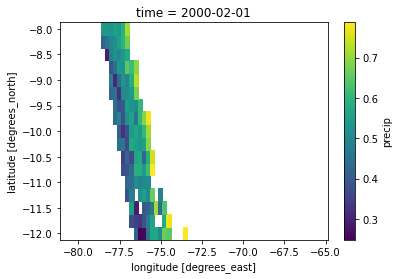

In [658]:
ndvi_month['precip'].isel(time=0).plot()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


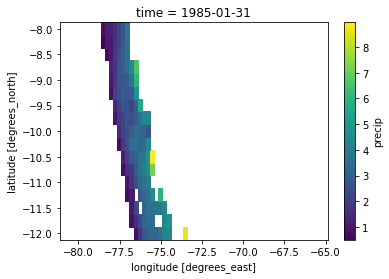

In [659]:
chirp_month.isel(time=0).plot()

In [660]:
cy = chirp_month.mean(['latitude', 'longitude']).sel(time=(chirp_month['time.year']>=2000)).load().rolling(time=5, min_periods=2, center=True).mean()
cymean = cy.groupby(cy['time.month']).mean()
ny = ndvi_month['precip'].mean(['latitude', 'longitude']).rolling(time=5, min_periods=2, center=True).mean()
nymean = ny.groupby(ny['time.month']).mean()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [661]:
cano = cy.groupby('time.month') - cymean
nano = ny.groupby('time.month') - nymean

(0.3754227155784426, 5.216645261690274e-09)

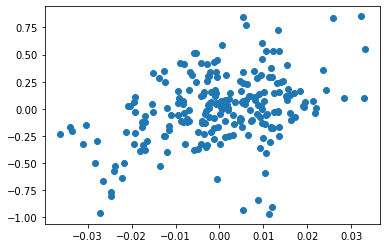

In [662]:
x = nano.values[cano.values[0:-1]<1]
y = (cano[0:-1])[cano[0:-1]<1]
plt.scatter(x, y)
stats.pearsonr(x,y)

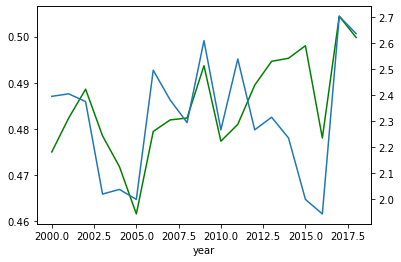

In [663]:
f = plt.figure()
ax = f.add_subplot(111)
ny.groupby(ny['time.year']).mean().plot(color='g')
ax1 = ax.twinx()
cy.groupby(cy['time.year']).mean().plot()

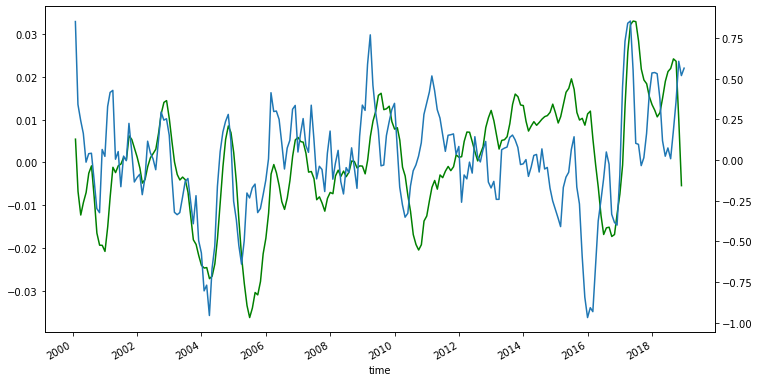

In [664]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
nano.plot(color='g')
ax1 = ax.twinx()
cano.plot()

In [665]:
len(cano)

228

In [666]:
len(nano)

227

In [667]:
stats.pearsonr(nano[0::],cano[0:-1])

(0.3754227155784426, 5.216645261690274e-09)

In [671]:
def calc_trend(mean_years, method='polyfit', sig=False, wilks=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])


    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.01,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0

    ddtrend = dtrend['slope']

    if wilks and sig:
        try:
            pthresh = us.fdr_threshold(dtrend['pval'].values[np.isfinite(dtrend['pval'].values)], alpha=alpha)
            ddtrend.values[(dtrend['pval'].values > pthresh) | np.isnan(dtrend['pval'].values)] = np.nan
        except ValueError:
            ddtrend.values = ddtrend.values * np.nan
            pthresh = np.nan
        print('p value threshold', pthresh)
    #ipdb.set_trace()
    # unstack back to lat lon coordinates
    return ddtrend

In [690]:
wet_yearly3 = (wet_test.where(wet_test==3).groupby(wet_test['time.month']).count()/3)#.mean('year')
wet_yearly5 = (wet_test.where(wet_test==5).groupby(wet_test['time.month']).count()/5)#.mean('year')
wet_yearly7 = (wet_test.where(wet_test==7).groupby(wet_test['time.month']).count()/7)#.mean('year')

In [694]:
dry_yearly3 = (dry_test.where(dry_test==3).groupby(dry_test['time.month']).count()/3)#.mean('year')/3
dry_yearly5 = (dry_test.where(dry_test==5).groupby(dry_test['time.month']).count()/5)#.mean('year')/5
dry_yearly7 = (dry_test.where(dry_test==7).groupby(dry_test['time.month']).count()/7)#.mean('year')/7

In [697]:
import seaborn as sns
colord = sns.color_palette("magma_r")

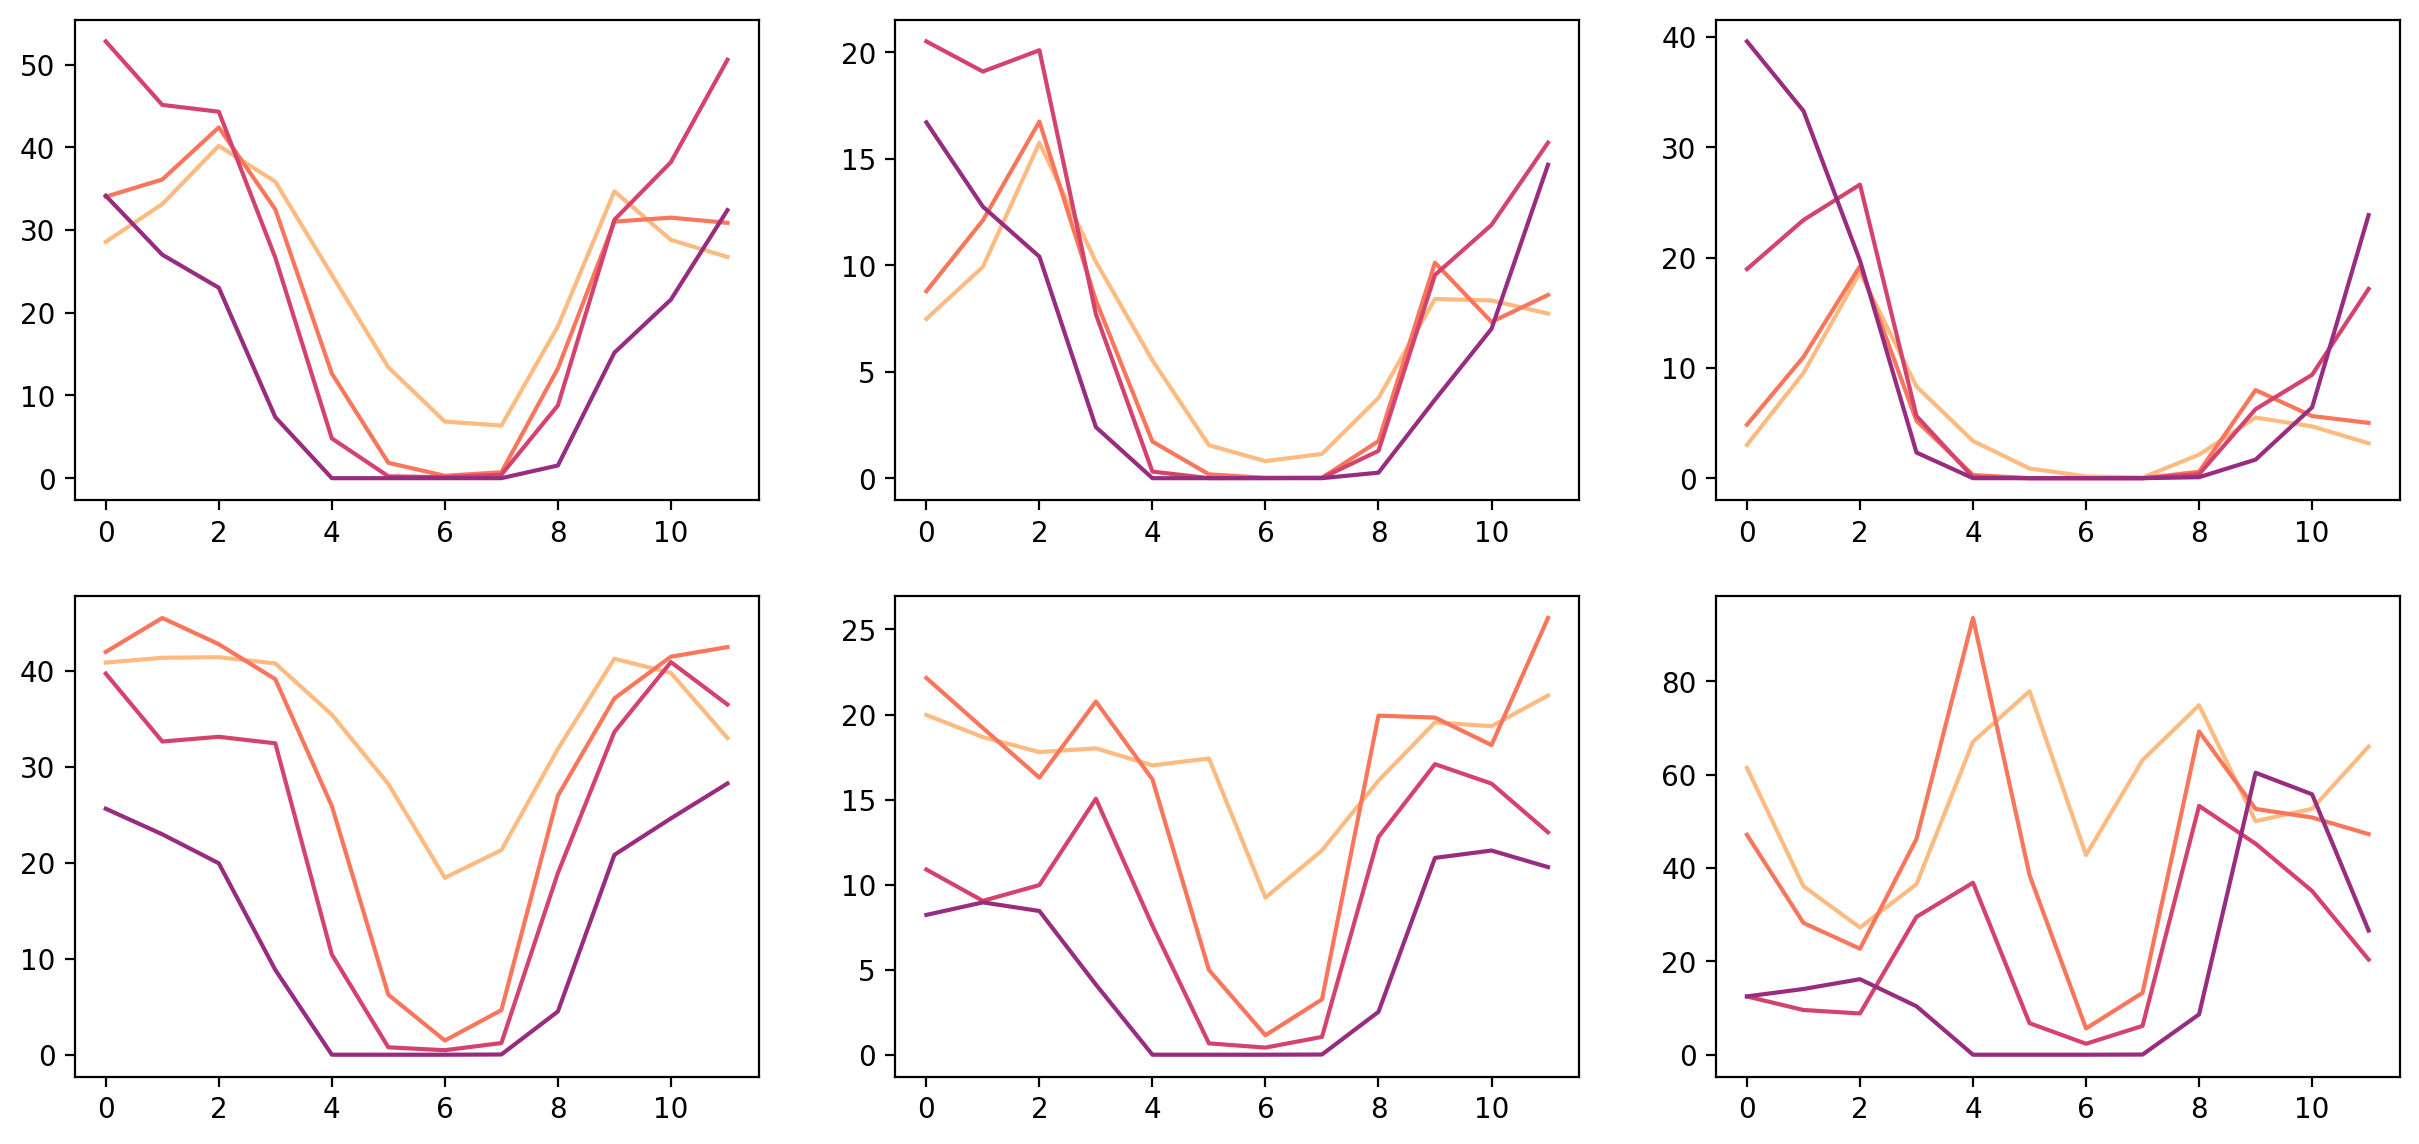

In [709]:
f = plt.figure(figsize=(15,7), dpi=200)
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)

ax5 = f.add_subplot(234)
ax6 = f.add_subplot(235)
ax7 = f.add_subplot(236)

cnt=0
for ids, r in enumerate(regions.keys()):
    alls = regions[r]
    
    for ww, axx in zip((wet_yearly3,wet_yearly5, wet_yearly7), (ax,ax2,ax3)):
        #ax = f.add_subplot(2,4,cnt+1)
        wplot = ww.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
        axx.plot(wplot, color=colord[cnt])
        
    for dd, axxx in zip((dry_yearly3,dry_yearly5, dry_yearly7), (ax5,ax6,ax7)):
        #axx = f.add_subplot(2,4,cnt+5)
        dplot = dd.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
        axxx.plot(dplot, color=colord[cnt])
    cnt +=1

In [685]:
wet_max = wet_yearly3.copy(deep=True)
wet_max.values[wet_yearly3>0] = 3
wet_max.values[wet_yearly5>wet_yearly3] = 5
wet_max.values[wet_yearly7>wet_yearly5] = 7
wet_max.values[wet_yearly7>wet_yearly3] = 7

In [686]:
dry_max = dry_yearly3.copy(deep=True)
dry_max.values[dry_yearly3>0] = 3
dry_max.values[dry_yearly5>dry_yearly3] = 5
dry_max.values[dry_yearly7>dry_yearly5] = 7
dry_max.values[dry_yearly7>dry_yearly3] = 7

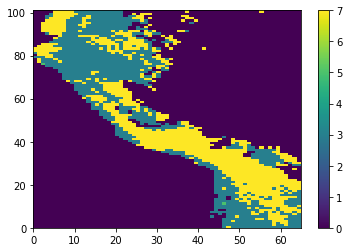

In [687]:
plt.pcolormesh(wet_max)
plt.colorbar()

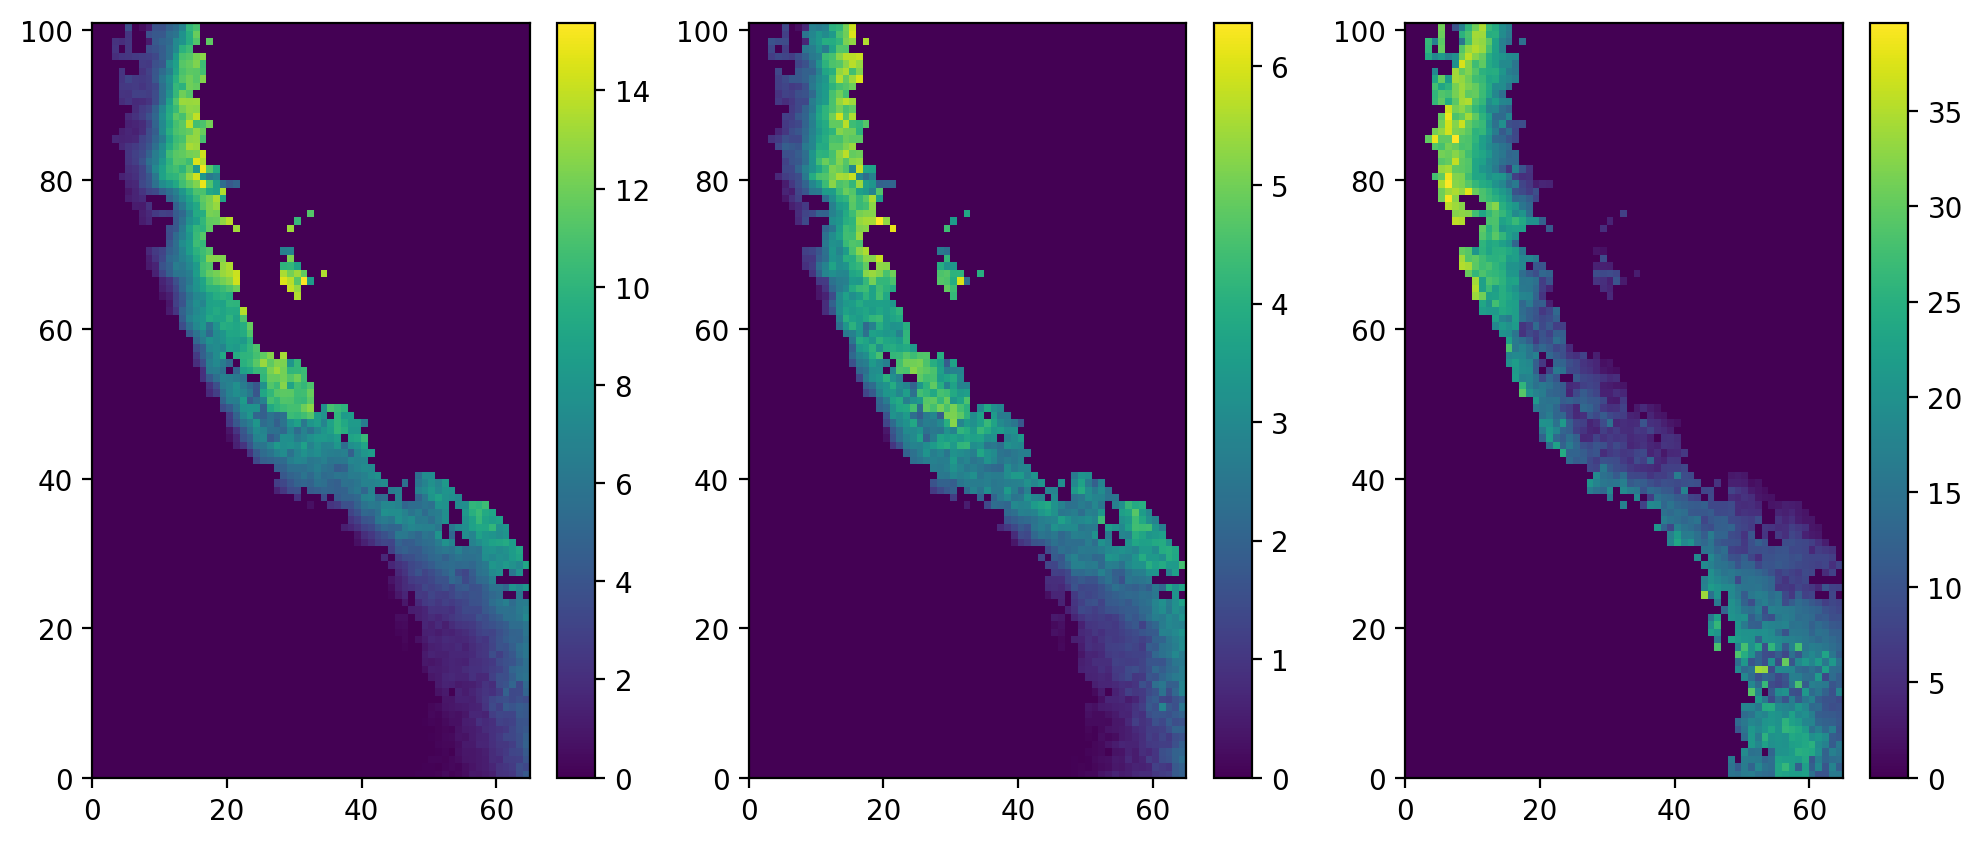

In [389]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(dry_yearly3)
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(dry_yearly5)
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(dry_yearly7)
plt.colorbar()

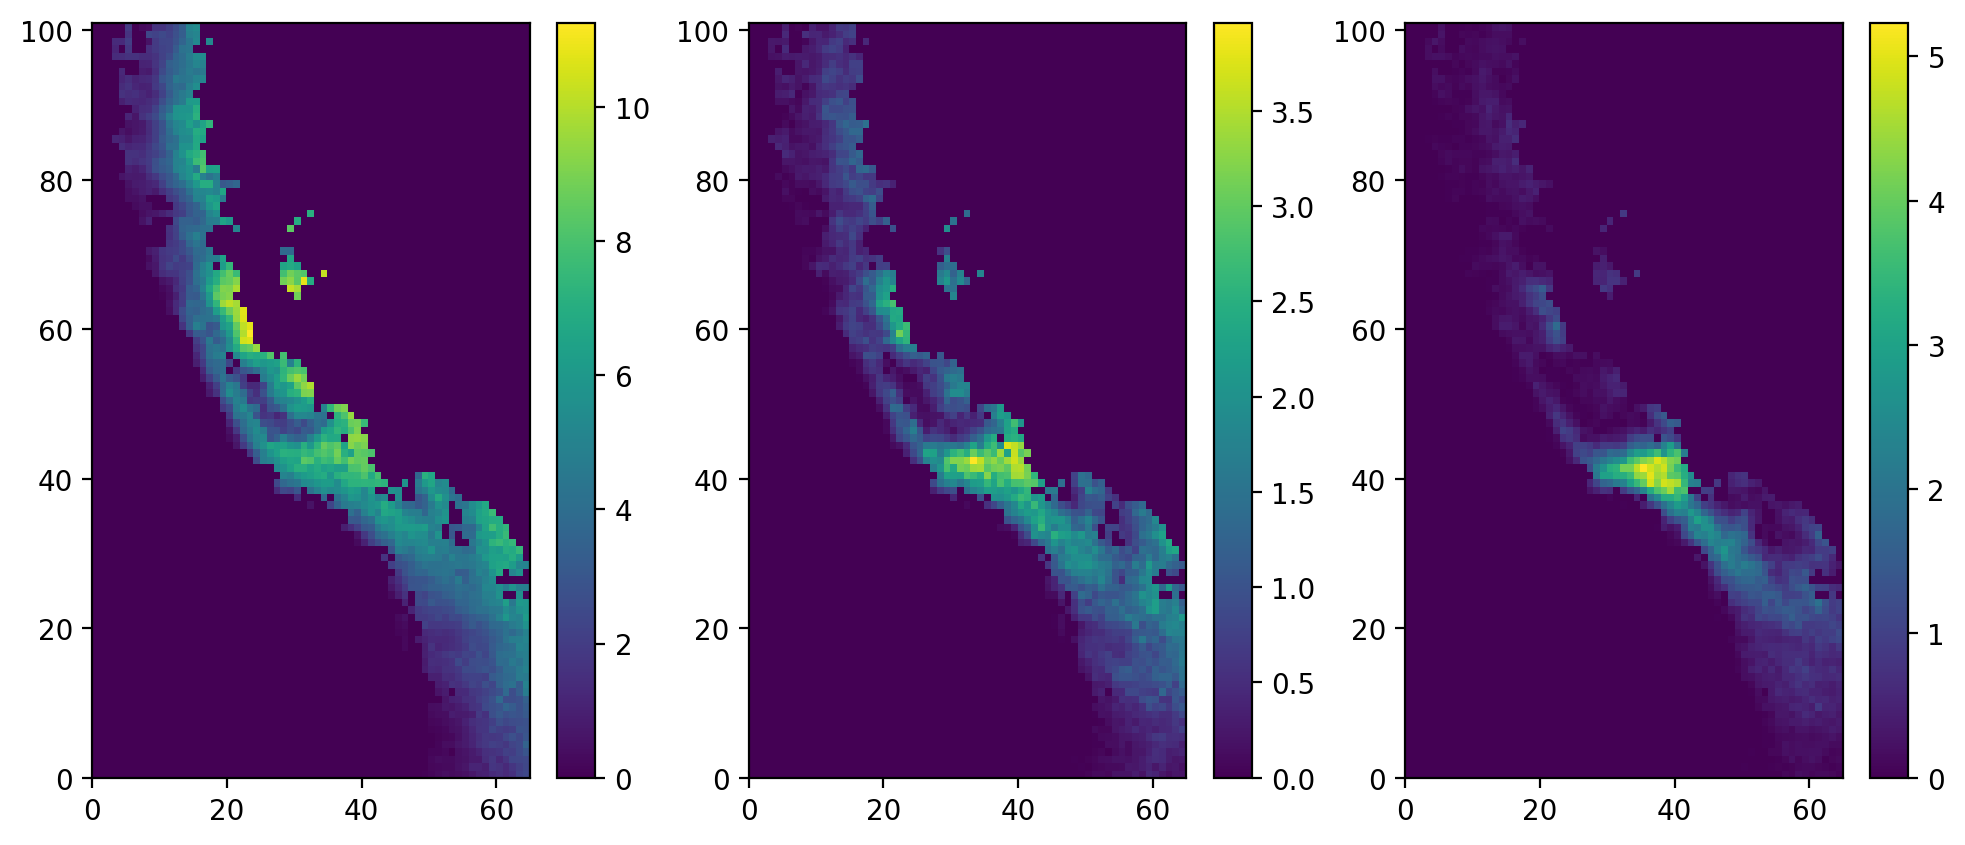

In [390]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(wet_yearly3)
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(wet_yearly5)
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(wet_yearly7)
plt.colorbar()

In [410]:
test_trend3 = calc_trend(wet_yearly3, sig=True)
test_trend5 = calc_trend(wet_yearly5, sig=True)
test_trend7 = calc_trend(wet_yearly7, sig=True)

Entering trend calc
Entering trend calc
Entering trend calc


In [411]:
dry_trend3 = calc_trend(dry_yearly3, sig=True)
dry_trend5 = calc_trend(dry_yearly5, sig=True)
dry_trend7 = calc_trend(dry_yearly7, sig=True)

Entering trend calc
Entering trend calc
Entering trend calc


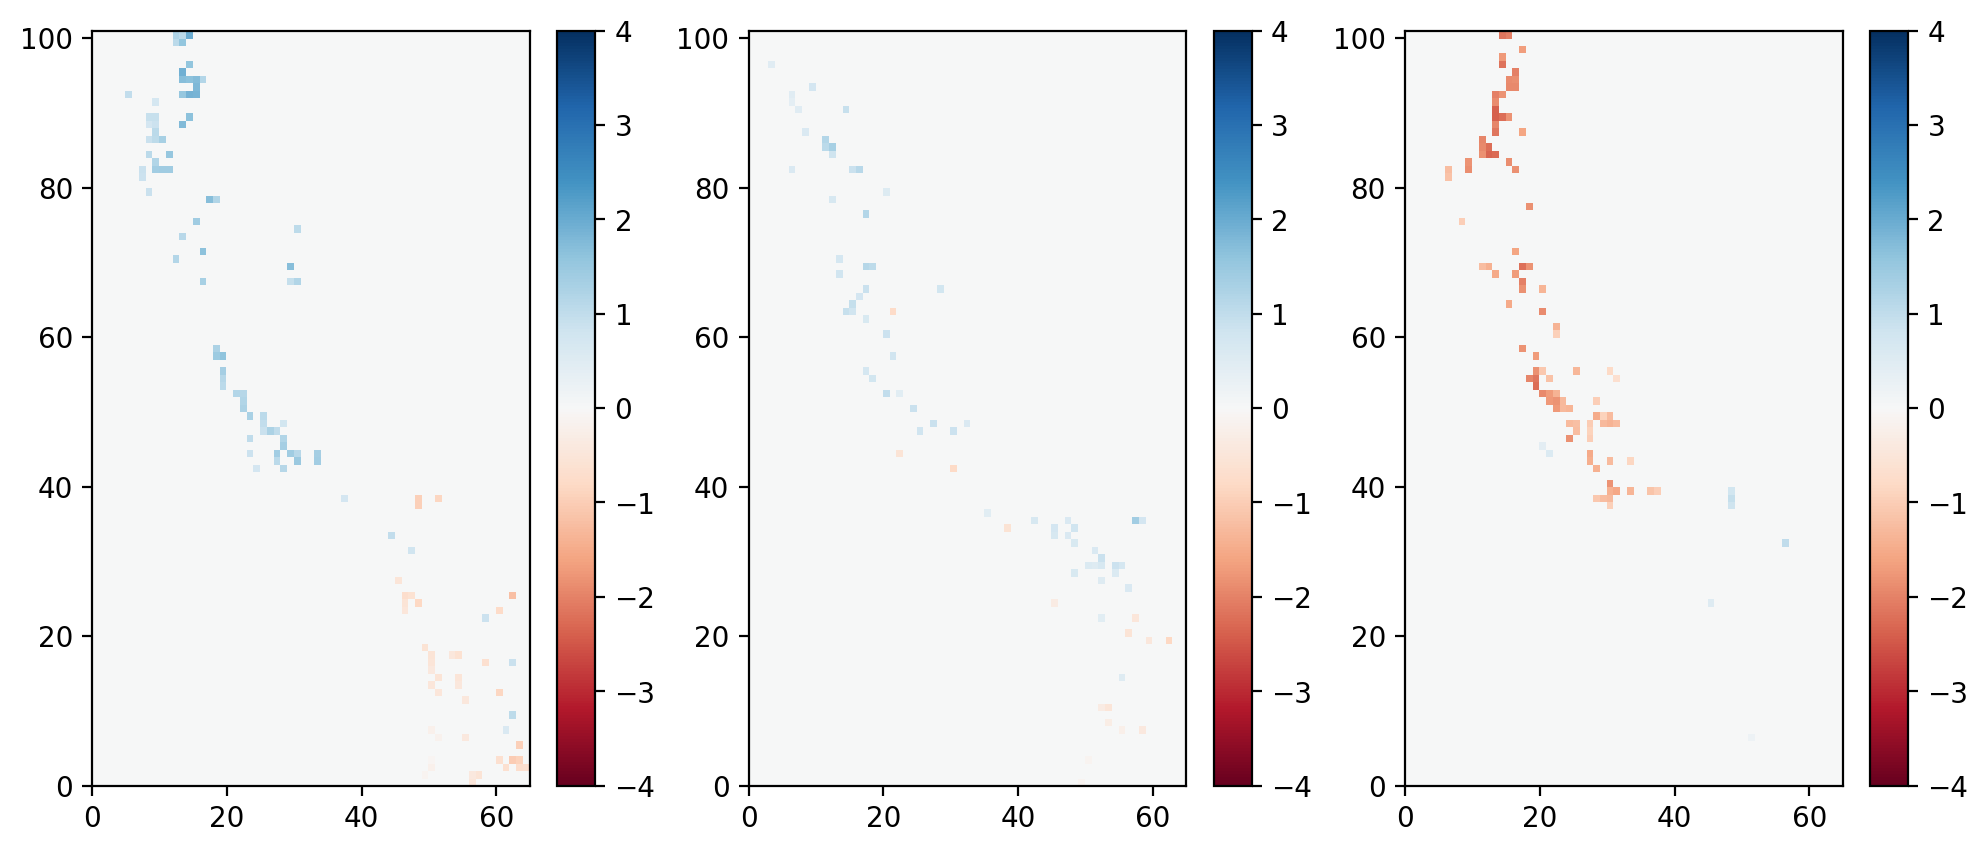

In [412]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(dry_trend3*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(dry_trend5*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(dry_trend7*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

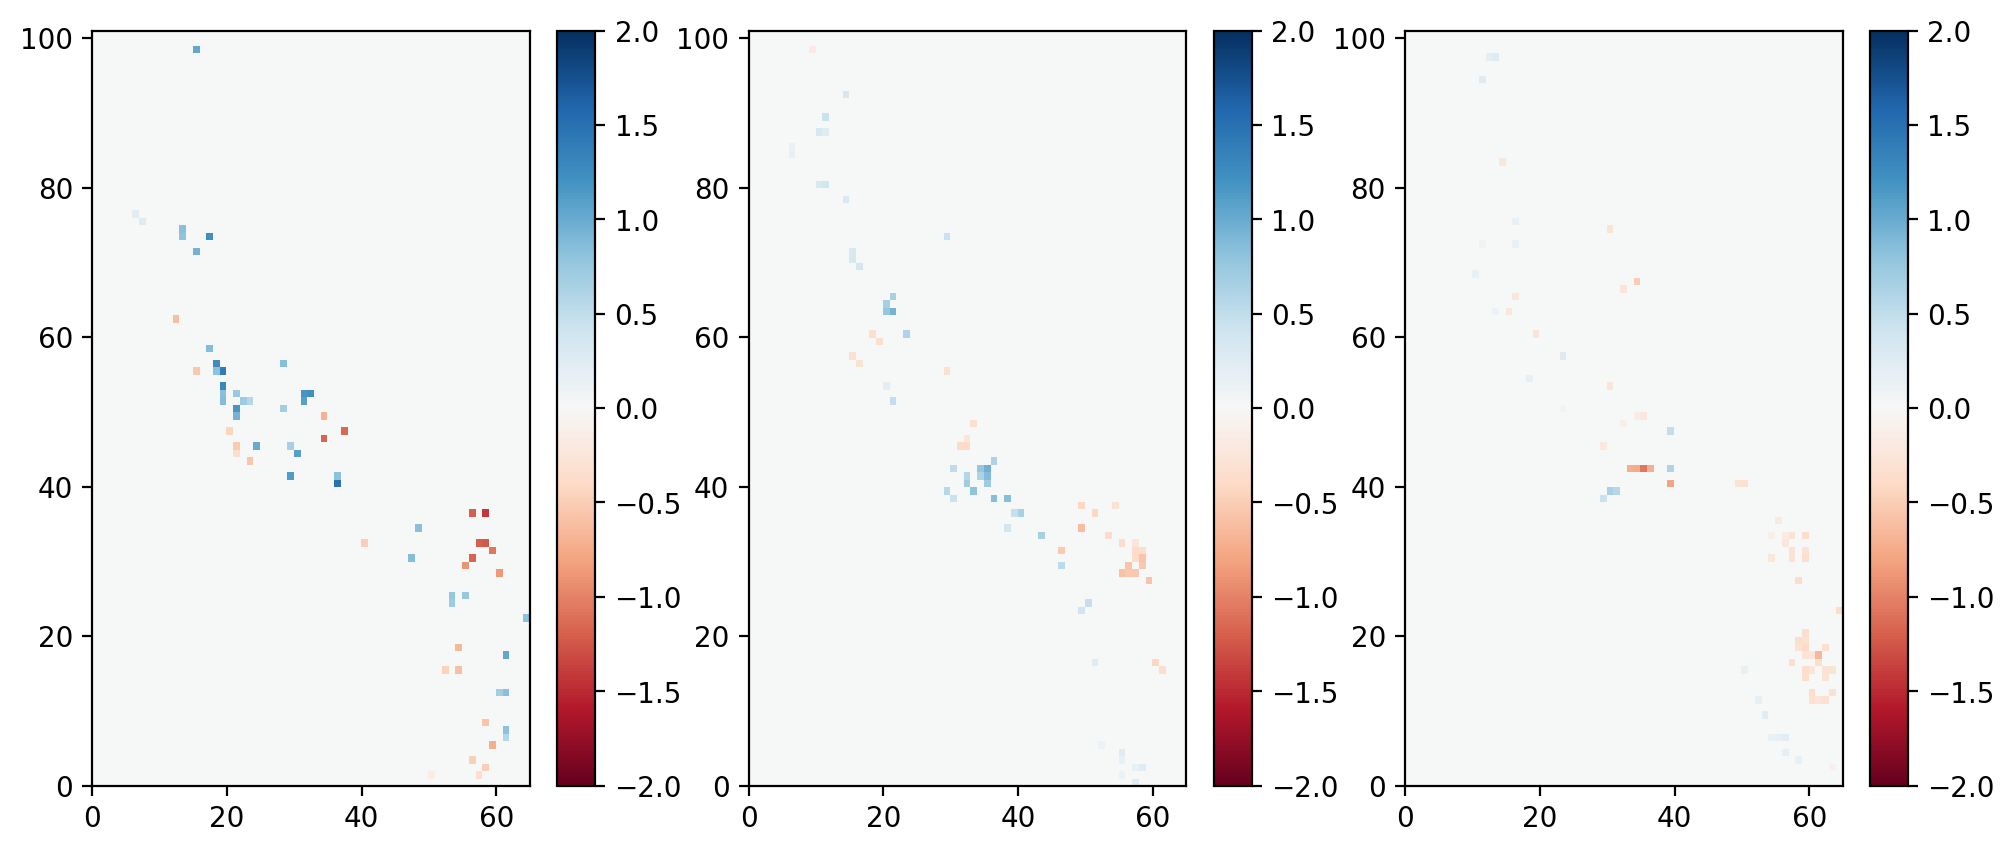

In [414]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(test_trend3*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(test_trend5*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(test_trend7*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

In [479]:
hua_wet, all_wet, filtered = dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, wet=True, box=alti_box)

Box onset 276.5 Date 03/10
Box retreat 103.0 Date 13/04


In [480]:
hua_dry, all_dry, filtered_dry = dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, box=alti_box)

Box onset 276.5 Date 03/10
Box retreat 103.0 Date 13/04


In [192]:
emean = era.sel(longitude=slice(hua_box[0],hua_box[1]), latitude=slice(hua_box[2], hua_box[3])).mean(['latitude', 'longitude'])

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['year']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


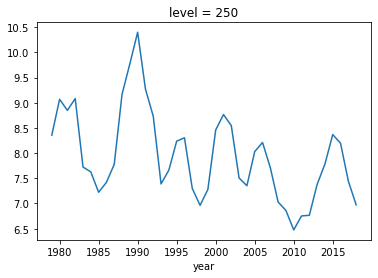

In [212]:
emean['u'].where((emean['time.month']>=9)).groupby(emean['time.year']).std().rolling(year=3, min_periods=2, center=True).mean(dim='year').plot()

In [ ]:

corr_sig = corr_all.where(corr_all['pval']<=0.05)
# mask = corr_sig.dayofyear>213
# corr = corr_sig.sel(dayofyear=mask)

array = corr_sig['r']
thresh = -0.1
array = array.where(array<thresh, other=0)  # T threshold maskout

In [ ]:
array.sel(longitude=-77.25, latitude=-9.5).plot()

In [ ]:
np.sum(array.sel(longitude=-77.25, latitude=-9.5).values[-75::]<-0.1)/ 75   #x = 15 , y=62

In [ ]:
ts = array.sel(longitude=-77.25, latitude=-9.5).values
labels, numL = label((ts == 0).astype(int))#label(ts)

In [402]:
def find_doy_max(corr_all, start, end, gt_doy=None, lt_doy=None):

    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60
        
    corr = corr_all#.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r']

    thresh = -0.1
    array = array.where(array<thresh, other=0) # T threshold maskout # set ocean nans to 0
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    corr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            #ipdb.set_trace()
            ts = array.isel(longitude=x, latitude=y)
            starts = start.values[y,x]
            ends = end.values[y,x]
            
            if np.isnan(starts) | np.isnan(ends):
                continue
            
            #ipdb.set_trace()
            valmax = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).argmax()
            #ipdb.set_trace()
            doys = (ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).dayofyear.values+1)[valmax]
            month = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys - 1)+' days')
            outarr_max[y,x] = month.month
            corr_max[y,x] = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends)))[valmax]
            
    out_max = xr.DataArray(outarr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    corr_out_max = xr.DataArray(corr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])

    return out_max, corr_out_max

In [403]:
outmax_gt, corrmax = find_doy_max(corr_all, outarr_3, endarr_5, gt_doy=213)

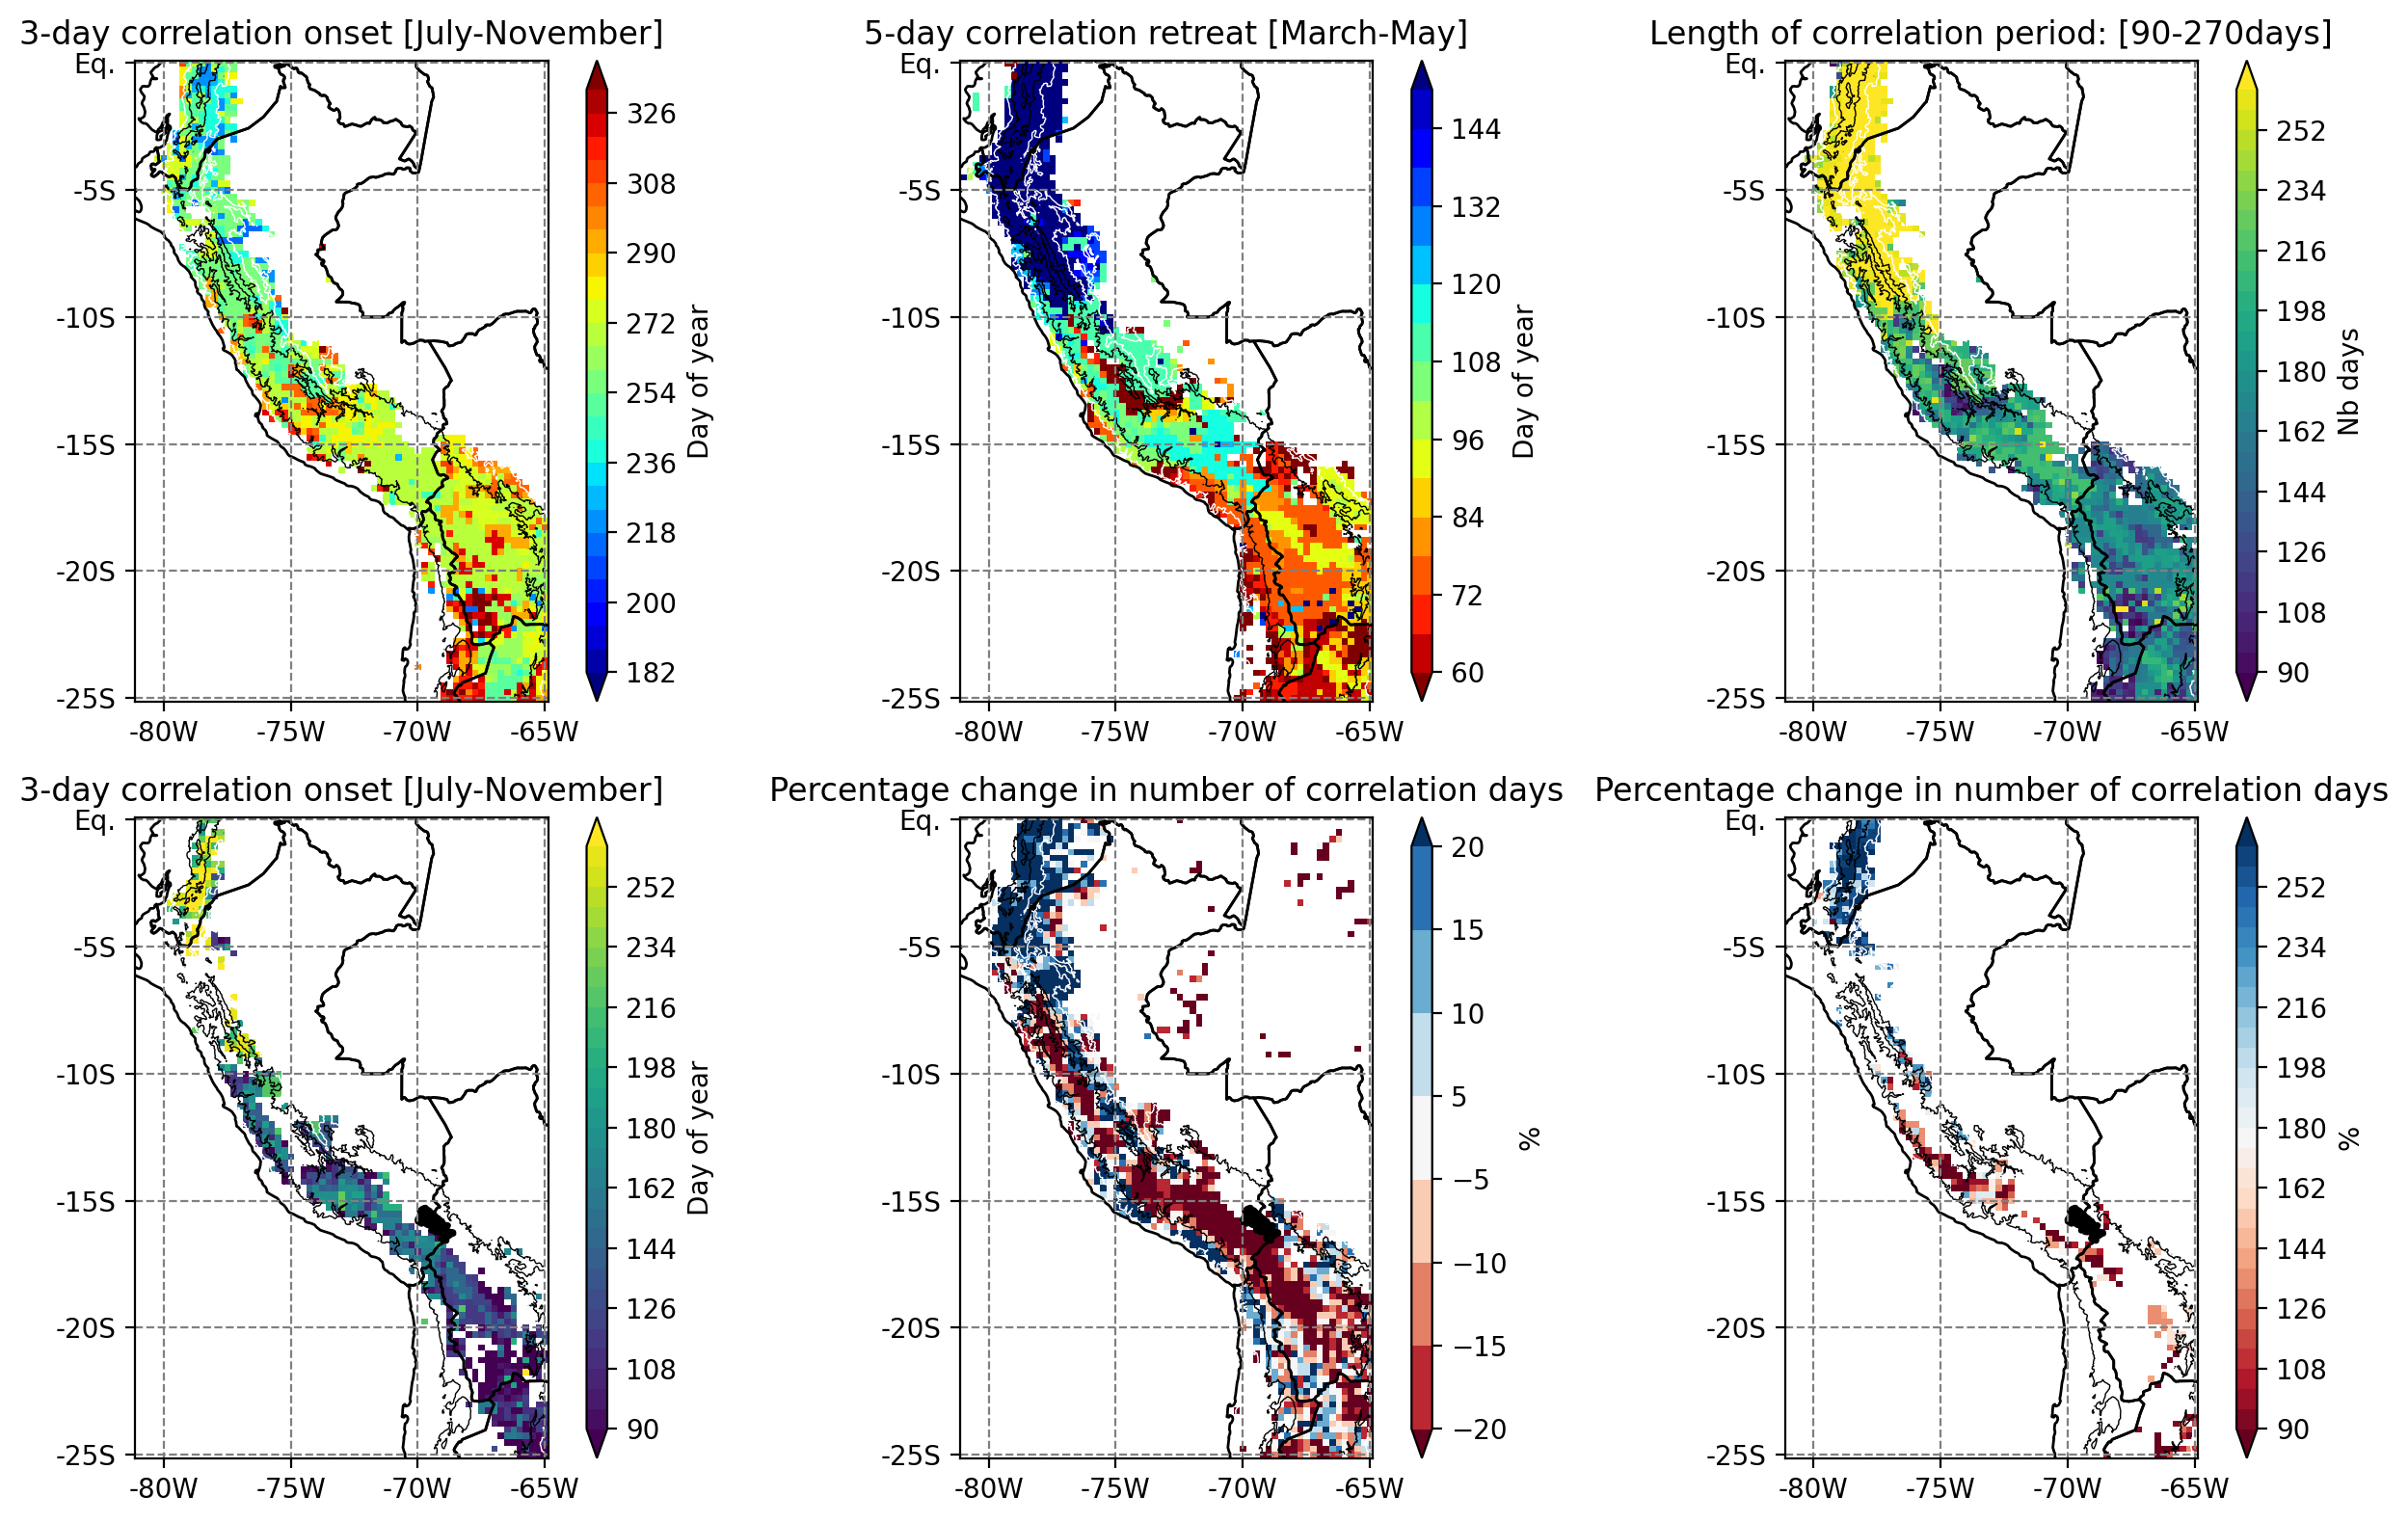

In [398]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(13,8), dpi=200)

ax = f.add_subplot(231)
outarr_3.values[(topo_on_g<300)]=np.nan
map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(232)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = ((365-outarr_3f)+endarr_5f)
map.set_data(data)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(235)
data = ((corr_end_num-corr_first_num)/corr_first_num)*100
data.values[corr_first_num.values<30]=np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(236)
data = ((365-outarr_3e)+endarr_5e)#((era_end-era_all)-3)/era_all*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=np.arange(90,270,6), cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr.png')

In [399]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.25)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3.values[y,x], 'Date', dstr)
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5.values[y,x], 'Date', dstr)

Huaraz onset 254.0 Date 11/09
Huaraz retreat 153.0 Date 02/06


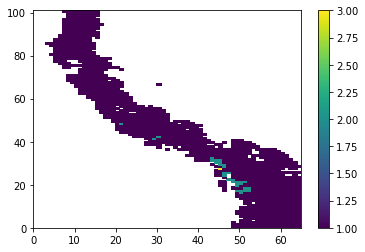

In [405]:
plt.pcolormesh(outmax_gt)
plt.colorbar()

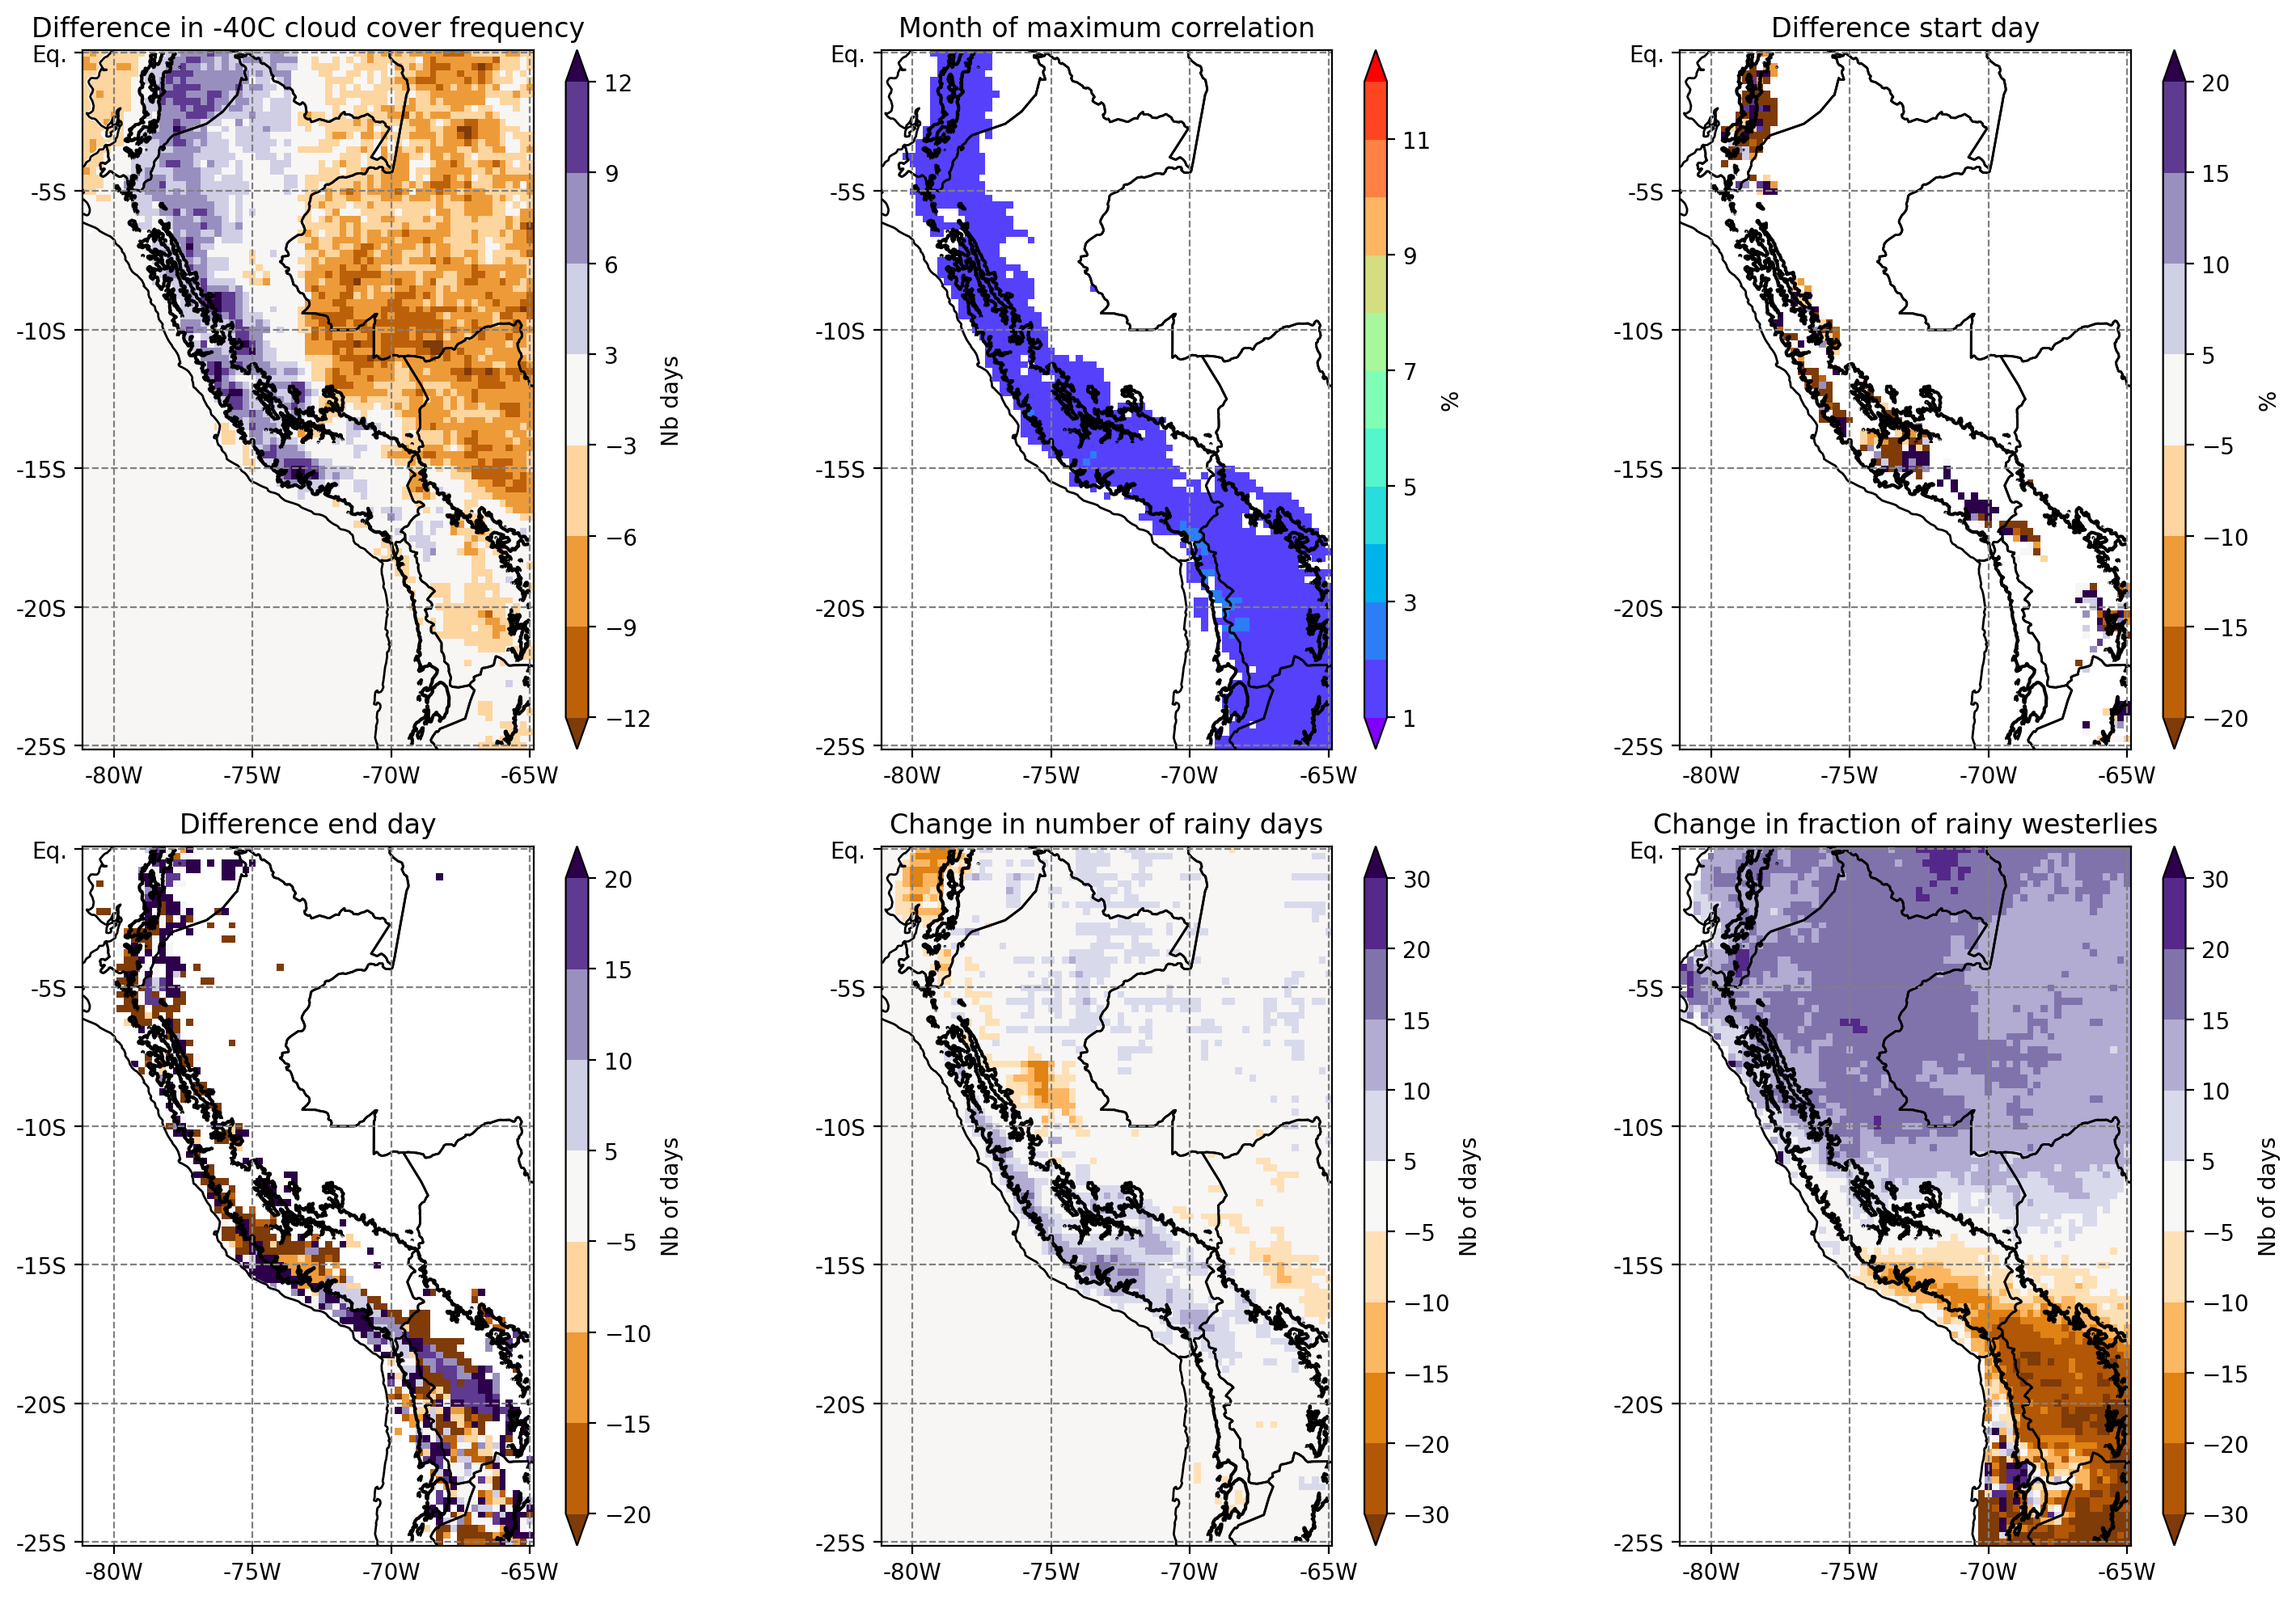

In [404]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)


f = plt.figure(figsize=(15,10), dpi=200)

box = [-85,-74,-10,-5]
map = corr_all.salem.get_map()
#.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3]))
topo = topo#.sel(lon=slice(box[0],box[1]), lat=slice(box[2], box[3]))

# ax = f.add_subplot(231)
# #outarr_3.values[(topo_on_g<300)]=np.nan
# map.set_data(outarr_3)
# map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)
# map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

# ax = f.add_subplot(232)
# endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
# map.set_data(endarr_5)
# map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(231)
#endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (g_end-g_all)
map.set_data(season)
map.set_plot_params(levels=[-12, -9,-6, -3, 3,6,9,12], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Difference in -40C cloud cover frequency')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(232)
data = outmax_gt
# data.values[(corr_first_num.values<30)]=np.nan
# data.values[np.isnan(season)] = np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=np.arange(1,13,1), cmap='rainbow', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Month of maximum correlation')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = outarr_3e-outarr_3f
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Difference start day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = endarr_5e-endarr_5f
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Difference end day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(235)

data = (ch_end-ch_all)#/ch_all*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of rainy days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)


ax = f.add_subplot(236)

data = (ch_end_frac-ch_all_frac)/ch_all_frac*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in fraction of rainy westerlies')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()